# Quantum State Tomography using Spiking Neural Networks (SNNs)

author: jajapuram shiva sai

course: Fundamentals of AI/ML


## Motivation and Applications

### Why Quantum State Tomography?

1. **Qubit Characterization and Diagnostics**  
   Identify noise, decoherence, and crosstalk in quantum hardware.

2. **Quantum Algorithm Verification**  
   Verify intermediate or final states produced by quantum algorithms.

3. **Quantum Machine Learning (QML)**  
   Train quantum models (like QGANs or QNNs) using state data reconstructed via SNNs.

4. **Peaked Quantum Circuits**  
   In circuits where output distributions are sharply peaked, SNNs can rapidly adapt to detect rare events.

5. **Neural Quantum Interfaces (NQI)**  
   SNNs can act as neuromorphic controllers that interpret qubit outputs in real time.

6. **Quantum Sensing and Metrology**  
   Use reconstructed states for enhanced phase estimation and precision measurement.

7. **Bridging Classical ML and Quantum Data**  
   SNNs allow **quantum measurement data** to be embedded directly into classical neuromorphic pipelines.

---

##  Methodology

### (a) Dataset Generation
- Simulated quantum states using **Qiskit** or **PennyLane**.
- Measurement data collected using **Symmetric Informationally Complete (SIC) POVMs**:
  \[
  \text{SIC-POVM} = \{ \Pi_i = \frac{1}{d} |\psi_i\rangle \langle\psi_i| \}
  \]
  where \(d\) = dimension of Hilbert space.
- Each measurement outcome provides probabilistic data \(p_i = \text{Tr}(\rho \Pi_i)\).
- Multiple shots used to simulate measurement noise.

### (b) Model Architecture
- Input layer encodes spike trains corresponding to measurement outcomes.
- Hidden layers use **Leaky Integrate-and-Fire (LIF)** neurons.
- Output layer reconstructs the density matrix vector (flattened form).

Architecture Example:
Input (SIC-POVM data)
↓
LIF Layer 1
↓
LIF Layer 2
↓
Readout Layer → Reconstructed density matrix (ρ̂)

### (c) Loss Function
Custom **Quantum Fidelity-based Loss**:

$$
\mathcal{L}_{\text{fidelity}} = 1 - F(\rho_{\text{true}}, \rho_{\text{reconstructed}})
$$

where

$$
F(\rho_1, \rho_2) = \left( \text{Tr}\sqrt{\sqrt{\rho_1}\rho_2\sqrt{\rho_1}} \right)^2
$$

This ensures the network learns to reconstruct states with high quantum similarity.

### (d) Training Methods
- **Surrogate gradient descent** used to train SNNs (handles non-differentiable spike functions).
- Optimizer: Adam / RMSProp.
- Epochs: 50–100 depending on convergence.
- Models compared: MLP, CNN, RNN, and SNN.

---


## Results and Analysis

### (a) Training Convergence
- **Loss vs Epoch**: SNN achieves faster convergence and smoother loss trajectory.
- **Fidelity vs Epoch**: Higher final fidelity (> 0.91 for 2-qubit SIC POVM).

### (b) Shots vs Fidelity
- SNN maintains robust fidelity even under shot noise (low number of shots).
- Outperforms classical models in low-data regimes.

### (c) Power Efficiency
- SNN consumes significantly lower power due to event-driven computation.
- Energy consumption comparison (per inference):

| Model                  | Energy (pJ) | Operations | Sparsity (%) |
|------------------------|-------------|------------|--------------|
| SNN (Neuromorphic)     | 1,457,017.9 | 31,743     | 79.33        |
| Transformer (GPU)      | 1,821,747.2 | 396,032    | 0.00         |

- **SNN Speedup**: 1.25× more energy efficient
- **Power Reduction**: 20.02%
- **Key Advantage**: 79.3% sparsity in spiking activity reduces computational overhead

This highlights suitability for **edge devices, cryogenic systems, and neuromorphic chips** where power constraints are critical.

### (d) Visualization
Plots included:
- Loss vs Epoch (for all models)
- Fidelity vs Epoch (for all models)
- Shots vs Fidelity
- Power efficiency comparison
- 3D histogram of |ρ_actual| vs |ρ_reconstructed|

The 3D histogram shows accurate reconstruction with minimal off-diagonal deviation.

---


# Setup and Configuration

In [1]:

# ------------------ Imports & Config ------------------
import os, math, random, time
from itertools import product
import numpy as np
import tqdm
import scipy.linalg
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import snntorch as snn
from snntorch import surrogate
from snntorch import Leaky

import pennylane as qml

# ------------------ Global config ------------------
N_QUBITS = 2
d = 2**N_QUBITS
N_OUT = 4**N_QUBITS

NUM_TRAIN_CIRCUITS = 60
NUM_VAL_CIRCUITS = 15
TRAIN_SAMPLES_PER_CIRCUIT = 80
VAL_SAMPLES_PER_CIRCUIT = 80

# Curriculum: pretrain at high shots, then fine-tune at deployment shots
PRETRAIN_SHOTS = 1000
FINE_TUNE_SHOTS = 200
EVAL_SHOT_LIST = [50, 200, 1000]

# Poisson rate coding for SNN
POISSON_T = 200
POISSON_SCALE = 1.0

# SNN model/training
SNN_HIDDEN = 256
SNN_EPOCHS = 20         # longer than PRETRAIN_EPOCHS to enter fine-tune
BATCH_SIZE_SNN = 32
LR_SNN = 1e-3
WD_SNN = 1e-4
CLIP_SNN = 2.0
SURR_SLOPE = 70.0
LIF_BETA = 0.6
EPS_LABEL = 1e-6

# Transformer baseline (right-sized for L=16)
TRF_D_MODEL = 128        # was 256
TRF_N_HEAD = 4           # was 8
TRF_N_LAYERS = 2
TRF_EPOCHS = 20        # longer to actually fine-tune
BATCH_SIZE_TRF = 32
LR_TRF = 1e-3
WD_TRF = 1e-4
CLIP_TRF = 1.0

# RBM baseline (unchanged)
RBM_HIDDEN = 64
RBM_EPOCHS = 20
BATCH_SIZE_RBM = 32
LR_RBM = 1e-3
WD_RBM = 0.0

# New physics-aware losses
MEAS_LAMBDA = 0.5        # weight for measurement-consistency loss
LIN_LAMBDA  = 0.05       # weight for linear-inversion proximity penalty
EPS_MEAS = 1e-8          # stability for KL/MSE on probabilities
MEAS_USE_KL = True       # set False to switch to MSE

# Curriculum epochs
PRETRAIN_EPOCHS = 10
FINE_TUNE_EPOCHS = 10 #edit to match total epochs above

# Evaluation ensembles
SNN_EVAL_ENSEMBLES = 5   # average multiple spike draws at test-time
TRF_EVAL_ENSEMBLES = 5   # average over mild Dirichlet jitters
DIRICHLET_ALPHA = 5.0    # for Transformer test-time jitter; set 0 to disable

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
print("DEVICE:", DEVICE)

DEVICE: cpu


# Data Generation and Encoding

In [2]:
# (Run once in Colab / fresh env if needed)
# !pip install pennylane pennylane-lightning torch torchvision torchaudio snntorch scipy matplotlib numpy tqdm


# ------------------ Lightning device for circuit gen ------------------
try:
    dev_name = "lightning.qubit"
    dev = qml.device(dev_name, wires=N_QUBITS)
    print(f"Using PennyLane device: {dev_name}")
except Exception:
    dev_name = "default.qubit"
    dev = qml.device(dev_name, wires=N_QUBITS)
    print(f"Lightning not available; falling back to {dev_name}")

def random_nq_circuit(nq, depth=8):
    @qml.qnode(dev, interface="autograd")
    def circuit():
        for _ in range(depth):
            gate = random.choice(["h","rx","ry","rz","cx","cz"])
            if gate == "h":
                q = random.randrange(nq)
                qml.Hadamard(wires=q)
            elif gate in ("rx","ry","rz"):
                q = random.randrange(nq)
                angle = random.random()*2*math.pi
                if gate=="rx": qml.RX(angle, wires=q)
                elif gate=="ry": qml.RY(angle, wires=q)
                else: qml.RZ(angle, wires=q)
            else:
                a = random.randrange(nq)
                b = random.choice([i for i in range(nq) if i!=a])
                if gate=="cx": qml.CNOT(wires=[a,b])
                else: qml.CZ(wires=[a,b])
        return qml.state()
    return circuit

train_qnodes = [random_nq_circuit(N_QUBITS, depth=8) for _ in range(NUM_TRAIN_CIRCUITS)]
val_qnodes   = [random_nq_circuit(N_QUBITS, depth=8) for _ in range(NUM_VAL_CIRCUITS)]

def state_from_qnode(qnode):
    sv = np.asarray(qnode()).reshape(-1)
    return sv / np.linalg.norm(sv)

print("Simulating statevectors (train)...")
train_states = [state_from_qnode(qn) for qn in tqdm.tqdm(train_qnodes, desc="train states")]

print("Simulating statevectors (val)...")
val_states = [state_from_qnode(qn) for qn in tqdm.tqdm(val_qnodes, desc="val states")]

# ------------------ SIC POVM ------------------
def single_qubit_sic_states():
    t = 1.0/math.sqrt(3.0)
    bloch = [np.array([ t, t, t]), np.array([ t, -t, -t]),
             np.array([-t, t, -t]), np.array([-t, -t, t])]
    states = []
    for nx, ny, nz in bloch:
        theta = math.acos(np.clip(nz,-1.0,1.0))
        phi = math.atan2(ny, nx)
        ket = np.array([math.cos(theta/2.0), np.exp(1j*phi)*math.sin(theta/2.0)], dtype=np.complex64)
        states.append(ket/np.linalg.norm(ket))
    return states

SIC_1Q_states = single_qubit_sic_states()
SIC_1Q_proj = [np.outer(s, s.conj()).astype(np.complex64) for s in SIC_1Q_states]
SIC_tuples = list(product(range(4), repeat=N_QUBITS))
print("SIC outcomes:", len(SIC_tuples))

def precompute_sic_projectors():
    P = []
    for tup in SIC_tuples:
        M = SIC_1Q_proj[tup[0]]
        for q in tup[1:]:
            M = np.kron(M, SIC_1Q_proj[q])
        P.append(M.astype(np.complex64))
    return np.stack(P, axis=0)  # [N_OUT, d, d]

P_stack = precompute_sic_projectors()
# Torch version (for differentiable projection)
P_stack_t = torch.tensor(P_stack, dtype=torch.complex64, device=DEVICE)  # [N_OUT, d, d]

def sic_probs_from_state(statevec):
    v = np.asarray(statevec, dtype=np.complex64)
    probs = np.real(np.einsum('i, aij, j -> a', np.conj(v), P_stack, v)).astype(np.float32)
    probs = np.maximum(probs, 0.0)
    s = probs.sum()
    return probs/s if s>0 else probs

# SIC linear inversion (numpy)
def sic_invert_probs_to_rho(probs):
    coeff = (d+1)*probs - (1.0/d)
    rho = np.tensordot(coeff.astype(np.float32), P_stack, axes=([0],[0])).astype(np.complex64)
    rho = 0.5*(rho + rho.conj().T)
    tr = np.real(np.trace(rho))
    if tr > 0: rho = rho / tr
    return rho

# Replace your torch_sic_invert_to_rho with this version
def torch_sic_invert_to_rho(freqs_bt):   # [B, N_OUT] real
    # Make the affine coefficient complex to match P_stack_t (complex64)
    coeff = ((d + 1) * freqs_bt - (1.0 / d)).to(torch.complex64)
    # einsum: B,a  x  a,i,j -> B,i,j (complex64)
    rho = torch.einsum('ba,aij->bij', coeff, P_stack_t)
    rho = 0.5 * (rho + torch.conj(rho.transpose(-1, -2)))
    tr = torch.real(torch.einsum('bii->b', rho)).unsqueeze(-1).unsqueeze(-1)
    rho = rho / (tr + 1e-20)
    return rho




# ------------------ Encoders & datasets ------------------
def freq_to_poisson_spiketrain(freq_vector, T=POISSON_T, scale=POISSON_SCALE, rng=None):
    if rng is None: rng = np.random.RandomState()
    p = np.clip(freq_vector*scale, 0.0, 1.0)
    r = rng.rand(T, p.size).astype(np.float32)
    return (r < p).astype(np.float32)  # T x N_OUT

def build_dataset(state_list, samples_per_state, shots, rng_seed=1234):
    rng = np.random.RandomState(rng_seed)
    X_spike, X_freq, Y_rho = [], [], []
    for sv in tqdm.tqdm(state_list, desc=f"samples(shots={shots})"):
        probs = sic_probs_from_state(sv)
        rho = np.outer(sv, sv.conj()).astype(np.complex64)
        for _ in range(samples_per_state):
            counts = rng.multinomial(shots, probs)
            freqs = counts / float(np.sum(counts)) if np.sum(counts)>0 else counts
            spikes = freq_to_poisson_spiketrain(freqs, T=POISSON_T, scale=POISSON_SCALE, rng=rng)
            X_spike.append(spikes.astype(np.float32))
            X_freq.append(freqs.astype(np.float32))
            Y_rho.append(rho)
    return np.stack(X_spike,0), np.stack(X_freq,0), np.stack(Y_rho,0)

print("Building train dataset (pretrain shots)...")
Xsp_train_hi, Xf_train_hi, Y_train_hi = build_dataset(train_states, TRAIN_SAMPLES_PER_CIRCUIT, PRETRAIN_SHOTS, rng_seed=SEED)
print("Building train dataset (fine-tune shots)...")
Xsp_train_lo, Xf_train_lo, Y_train_lo = build_dataset(train_states, TRAIN_SAMPLES_PER_CIRCUIT, FINE_TUNE_SHOTS, rng_seed=SEED+1)
print("Building val dataset (fine-tune shots)...")
Xsp_val, Xf_val, Y_val = build_dataset(val_states, VAL_SAMPLES_PER_CIRCUIT, FINE_TUNE_SHOTS, rng_seed=SEED+2)

Using PennyLane device: lightning.qubit
Simulating statevectors (train)...


train states: 100%|██████████| 60/60 [00:00<00:00, 1196.41it/s]


Simulating statevectors (val)...


val states: 100%|██████████| 15/15 [00:00<00:00, 1270.77it/s]


SIC outcomes: 16
Building train dataset (pretrain shots)...


samples(shots=1000): 100%|██████████| 60/60 [00:00<00:00, 435.99it/s]


Building train dataset (fine-tune shots)...


samples(shots=200): 100%|██████████| 60/60 [00:00<00:00, 458.05it/s]


Building val dataset (fine-tune shots)...


samples(shots=200): 100%|██████████| 15/15 [00:00<00:00, 429.16it/s]


# Loss functions

In [3]:


# ------------------ Losses and helpers ------------------
I_d = np.eye(d, dtype=np.complex64)/d
I_d_t = torch.tensor(I_d, dtype=torch.complex64, device=DEVICE)

def fidelity_pure(rho_pred, rho_true):
    return float(np.real(np.trace(rho_pred @ rho_true)))

def torch_cholesky_params_to_rho(params, d, device):
    # params: (B, d^2) with first d = diag pre-activations, rest 2 per strict-lower entry (real, imag)
    B = params.shape[0]
    diag = params[:, :d]
    off = params[:, d:]
    diag_pos = torch.exp(diag)
    Tr = torch.zeros((B,d,d), dtype=torch.float32, device=device)
    Ti = torch.zeros((B,d,d), dtype=torch.float32, device=device)
    for i in range(d):
        Tr[:,i,i] = diag_pos[:,i]
    idx = 0
    for i in range(1,d):
        for j in range(0,i):
            Tr[:,i,j] = off[:, idx]
            Ti[:,i,j] = off[:, idx+1]
            idx += 2
    T = torch.complex(Tr, Ti)
    rho = T @ torch.conj(T.transpose(-1,-2))
    tr = torch.real(torch.einsum('bii->b', rho)).unsqueeze(-1).unsqueeze(-1)
    rho = rho / (tr + 1e-20)
    return rho

def np_vec_to_T(vec, d):
    vec = np.asarray(vec)
    T = np.zeros((d,d), dtype=np.complex64)
    idx = 0
    diag = vec[idx:idx+d]; idx += d
    diag_vals = np.exp(diag)
    for i in range(d):
        T[i,i] = diag_vals[i]
    for i in range(1,d):
        for j in range(0,i):
            re = vec[idx]; im = vec[idx+1]; idx += 2
            T[i,j] = re + 1j*im
    return T

def torch_fidelity_loss_pure(rho_pred, rho_true_t):
    overlap = torch.real(torch.einsum('bij,bji->b', rho_pred, rho_true_t))
    loss = torch.clamp(1.0 - overlap, min=0.0).mean()
    return loss

def torch_project_to_sic_probs(rho_pred):  # [B, d, d] -> [B, N_OUT]
    # Re Tr(rho Π_i)
    probs = torch.real(torch.einsum('bij,aij->ba', rho_pred, P_stack_t))
    probs = torch.clamp(probs, min=0.0)
    probs = probs / (probs.sum(dim=-1, keepdim=True) + 1e-20)
    return probs

def measurement_consistency_loss(p_in, p_hat):
    if MEAS_USE_KL:
        p = torch.clamp(p_in, min=EPS_MEAS)
        q = torch.clamp(p_hat, min=EPS_MEAS)
        return torch.mean(torch.sum(p * (torch.log(p) - torch.log(q)), dim=-1))
    else:
        return torch.mean(torch.sum((p_in - p_hat)**2, dim=-1))

# Model Architicture

In [4]:


# ------------------ Models ------------------
# Enhanced temporal front-end + deeper SNN head
class TemporalConv(nn.Module):
    def __init__(self, n_in, k=7, gru_hidden=64):
        super().__init__()
        self.conv1 = nn.Conv1d(n_in, n_in, kernel_size=k, padding=k//2, groups=n_in, bias=False, dilation=1)
        self.conv2 = nn.Conv1d(n_in, n_in, kernel_size=k, padding=2*(k//2), groups=n_in, bias=False, dilation=2)
        self.conv3 = nn.Conv1d(n_in, n_in, kernel_size=k, padding=4*(k//2), groups=n_in, bias=False, dilation=4)
        self.bn = nn.BatchNorm1d(n_in)
        # lightweight GRU
        self.gru = nn.GRU(n_in, gru_hidden, batch_first=True, bidirectional=False)
        self.gru_proj = nn.Linear(gru_hidden, n_in, bias=False)
        for conv in (self.conv1, self.conv2, self.conv3):
            nn.init.kaiming_uniform_(conv.weight, a=math.sqrt(5))
        nn.init.xavier_uniform_(self.gru_proj.weight)
    def forward(self, x_seq):   # (T, B, N)
        x = x_seq.permute(1,2,0)    # (B,N,T)
        x = self.conv1(x); x = self.conv2(x); x = self.conv3(x)
        x = self.bn(x); x = torch.relu(x)
        x = x.permute(0,2,1)        # (B,T,N)
        h,_ = self.gru(x)           # (B,T,H)
        x = self.gru_proj(h)        # (B,T,N)
        return x.permute(1,0,2)     # (T,B,N)

spike_grad = surrogate.fast_sigmoid(slope=SURR_SLOPE)

class SNN_Encoder(nn.Module):
    def __init__(self, n_in, n_hidden, out_len, dropout=0.1):
        super().__init__()
        self.temporal = TemporalConv(n_in, k=7, gru_hidden=64)
        self.fc1 = nn.Linear(n_in, n_hidden, bias=False); self.bn1 = nn.BatchNorm1d(n_hidden); self.lif1 = Leaky(beta=LIF_BETA, spike_grad=spike_grad)
        self.fc2 = nn.Linear(n_hidden, n_hidden, bias=False); self.bn2 = nn.BatchNorm1d(n_hidden); self.lif2 = Leaky(beta=LIF_BETA, spike_grad=spike_grad)
        self.fc3 = nn.Linear(n_hidden, n_hidden, bias=False); self.bn3 = nn.BatchNorm1d(n_hidden); self.lif3 = Leaky(beta=LIF_BETA, spike_grad=spike_grad)
        self.head1 = nn.Sequential(nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden), nn.ReLU(inplace=True), nn.Dropout(dropout))
        self.head2 = nn.Linear(n_hidden, n_hidden)
        self.readout = nn.Linear(n_hidden, out_len)
        for fc in (self.fc1, self.fc2, self.fc3):
            nn.init.kaiming_uniform_(fc.weight, a=math.sqrt(5))
        nn.init.xavier_uniform_(self.head2.weight); nn.init.xavier_uniform_(self.readout.weight)
    def forward(self, x_seq):  # (T,B,N)
        x_seq = self.temporal(x_seq)
        Tt,B,_ = x_seq.shape
        mem1 = self.lif1.init_leaky(); mem2 = self.lif2.init_leaky(); mem3 = self.lif3.init_leaky()
        acc = torch.zeros(B, self.fc3.in_features, device=x_seq.device)
        for t in range(Tt):
            h = self.fc1(x_seq[t]); h = self.bn1(h); spk1, mem1 = self.lif1(h, mem1)
            h = self.fc2(spk1);     h = self.bn2(h); spk2, mem2 = self.lif2(h, mem2)
            h = self.fc3(spk2);     h = self.bn3(h); spk3, mem3 = self.lif3(h, mem3)
            acc += mem3
        acc = acc/float(Tt)
        res = self.head1(acc); res = self.head2(res) + acc; res = torch.relu(res)
        return self.readout(res)
    
class QSTTransformer(nn.Module):
    def __init__(self, n_features, d_model, n_heads, n_layers, out_len):
        super().__init__()
        # No positional encoding (outcomes are exchangeable)
        self.inp = nn.Linear(n_features, d_model)
        
        # Use DeepSets-style architecture or remove pos encoding
        enc_layer = nn.TransformerEncoderLayer(
            d_model, n_heads, 
            dim_feedforward=4*d_model,
            batch_first=True
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        
        # Global pooling instead of CLS
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, out_len)
        )
    
    def forward(self, freqs):  # [B, 16]
        # Treat each outcome as a feature vector
        x = freqs.unsqueeze(-1)  # [B, 16, 1]
        x = self.inp(x)          # [B, 16, d_model]
        
        # Self-attention without positional bias
        x = self.enc(x)          # [B, 16, d_model]
        
        # Mean pooling over all outcomes
        x = x.mean(dim=1)        # [B, d_model]
        
        return self.head(x)

# class QSTTransformer(nn.Module):
    

    def __init__(self, seq_len, d_model, n_heads, n_layers, out_len):
        super().__init__()
        self.cls = nn.Parameter(torch.randn(1,1,d_model)*0.02)
        self.inp = nn.Linear(1, d_model)
        self.pos = nn.Parameter(torch.randn(1, seq_len+1, d_model)*0.01)
        enc_layer = nn.TransformerEncoderLayer(d_model, n_heads, dim_feedforward=4*d_model,
                                               batch_first=True, activation='gelu', norm_first=True)
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, out_len))
    def forward(self, freqs):  # B x L
        B,L = freqs.shape
        x = freqs.unsqueeze(-1)                 # B x L x 1
        x = self.inp(x)                         # B x L x d_model
        cls_tok = self.cls.expand(B, -1, -1)    # B x 1 x d_model
        x = torch.cat([cls_tok, x], dim=1)      # B x (L+1) x d_model
        x = x + self.pos[:, :L+1]
        h = self.enc(x)[:,0,:]                  # CLS pooling
        return self.head(h)

class ConditionalRBM(nn.Module):
    def __init__(self, n_freq, n_hidden, out_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_freq, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU()
        )
        self.decoder = nn.Linear(n_hidden, out_dim)
    def forward(self, freqs):
        h = self.encoder(freqs); return self.decoder(h)

# Training routines and utilities

In [5]:


# ------------------ Build models & tensors ------------------
param_len = d*d
n_in = N_OUT

snn_model = SNN_Encoder(n_in, SNN_HIDDEN, param_len).to(DEVICE)
opt_snn = torch.optim.AdamW(snn_model.parameters(), lr=LR_SNN, weight_decay=WD_SNN)
sched_snn = torch.optim.lr_scheduler.CosineAnnealingLR(opt_snn, T_max=SNN_EPOCHS, eta_min=1e-4)

trf_model = QSTTransformer(seq_len=N_OUT, d_model=TRF_D_MODEL, n_heads=TRF_N_HEAD,
                           n_layers=TRF_N_LAYERS, out_len=param_len).to(DEVICE)
opt_trf = torch.optim.AdamW(trf_model.parameters(), lr=LR_TRF, weight_decay=WD_TRF)
sched_trf = torch.optim.lr_scheduler.CosineAnnealingLR(opt_trf, T_max=TRF_EPOCHS, eta_min=1e-4)

rbm_model = ConditionalRBM(n_freq=N_OUT, n_hidden=RBM_HIDDEN, out_dim=param_len).to(DEVICE)
opt_rbm = torch.optim.AdamW(rbm_model.parameters(), lr=LR_RBM, weight_decay=WD_RBM)
sched_rbm = torch.optim.lr_scheduler.CosineAnnealingLR(opt_rbm, T_max=RBM_EPOCHS, eta_min=1e-4)

def to_torch_rho(Y_np):
    y_re = torch.tensor(np.real(Y_np), dtype=torch.float32, device=DEVICE)
    y_im = torch.tensor(np.imag(Y_np), dtype=torch.float32, device=DEVICE)
    return torch.complex(y_re, y_im)

# ------------------ Training & eval (with physics-aware losses) ------------------
def eval_subset_mean_fid_snn(model, shots=FINE_TUNE_SHOTS, ensembles=SNN_EVAL_ENSEMBLES):
    model.eval()
    fids = []
    with torch.no_grad():
        for sv in val_states[:min(6,len(val_states))]:
            rho_true = np.outer(sv, sv.conj()).astype(np.complex64)
            probs = sic_probs_from_state(sv)
            for _ in range(5):
                counts = np.random.multinomial(shots, probs)
                freqs = counts / float(np.sum(counts)) if np.sum(counts)>0 else counts
                # ensemble over spike draws
                params_acc = None
                for k in range(ensembles):
                    spikes = freq_to_poisson_spiketrain(freqs, T=POISSON_T, scale=POISSON_SCALE, rng=np.random.RandomState())
                    xb = torch.tensor(spikes[None].transpose(1,0,2), dtype=torch.float32, device=DEVICE)
                    out = model(xb).squeeze(0).detach().cpu().numpy()
                    params_acc = out if params_acc is None else params_acc + out
                out_avg = params_acc/float(ensembles)
                Tmat = np_vec_to_T(out_avg, d)
                rho_est = Tmat @ Tmat.conj().T
                rho_est = rho_est/np.trace(rho_est)
                fids.append(fidelity_pure(rho_est, rho_true))
    return float(np.mean(fids)) if fids else 0.0

def jitter_dirichlet(freqs_np, alpha=DIRICHLET_ALPHA):
    if alpha <= 0: return freqs_np
    alpha_vec = alpha * (freqs_np + 1e-6) * len(freqs_np)
    return np.random.dirichlet(alpha_vec)

def eval_subset_mean_fid_trf(model, shots=FINE_TUNE_SHOTS, ensembles=TRF_EVAL_ENSEMBLES):
    model.eval()
    fids = []
    with torch.no_grad():
        for sv in val_states[:min(6,len(val_states))]:
            rho_true = np.outer(sv, sv.conj()).astype(np.complex64)
            probs = sic_probs_from_state(sv)
            for _ in range(5):
                counts = np.random.multinomial(shots, probs)
                freqs = counts / float(np.sum(counts)) if np.sum(counts)>0 else counts
                # mild Dirichlet ensembling
                params_acc = None
                for k in range(ensembles):
                    f_ = jitter_dirichlet(freqs)
                    x = torch.tensor(f_[None,:], dtype=torch.float32, device=DEVICE)
                    out = model(x).squeeze(0)
                    rho_pred = torch_cholesky_params_to_rho(out[None,:], d, DEVICE).squeeze(0).detach().cpu().numpy()
                    params_acc = rho_pred if params_acc is None else params_acc + rho_pred
                rho_est = params_acc/float(ensembles)
                fids.append(fidelity_pure(rho_est, rho_true))
    return float(np.mean(fids)) if fids else 0.0

def snn_train_epoch(model, Xsp, Xf, Y, batch_size):
    model.train()
    N = Xsp.shape[0]
    perm = np.random.permutation(N)
    num_batches = math.ceil(N/batch_size)
    running = 0.0
    pbar = tqdm.tqdm(range(num_batches), desc="SNN batches", leave=False)
    for bi in pbar:
        idx = perm[bi*batch_size:(bi+1)*batch_size]
        xb = torch.tensor(Xsp[idx], dtype=torch.float32, device=DEVICE).permute(1,0,2) # T x B x N
        xfreq = torch.tensor(Xf[idx], dtype=torch.float32, device=DEVICE)             # B x N
        y_true = to_torch_rho(Y[idx])
        y_true = (1.0 - EPS_LABEL)*y_true + EPS_LABEL*I_d_t

        opt_snn.zero_grad(set_to_none=True)
        params = model(xb)
        rho_pred = torch_cholesky_params_to_rho(params, d, DEVICE)

        # Physics-aware losses
        p_hat = torch_project_to_sic_probs(rho_pred)
        l_meas = measurement_consistency_loss(xfreq, p_hat)
        rho_lin = torch_sic_invert_to_rho(xfreq)
        l_lin = torch.mean(torch.sum(torch.real((rho_pred - rho_lin)*torch.conj(rho_pred - rho_lin)), dim=(-1,-2)))
        l_fid = torch_fidelity_loss_pure(rho_pred, y_true)

        loss = l_fid + MEAS_LAMBDA*l_meas + LIN_LAMBDA*l_lin
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_SNN)
        opt_snn.step()
        running += float(loss.item())
        pbar.set_postfix({'loss': f"{float(loss.item()):.4e}"})
    return running/num_batches

def trf_train_epoch(model, Xf, Y, batch_size):
    model.train()
    N = Xf.shape[0]
    perm = np.random.permutation(N)
    num_batches = math.ceil(N/batch_size)
    running = 0.0
    pbar = tqdm.tqdm(range(num_batches), desc="TRF batches", leave=False)
    for bi in pbar:
        idx = perm[bi*batch_size:(bi+1)*batch_size]
        x = torch.tensor(Xf[idx], dtype=torch.float32, device=DEVICE)   # B x N
        y_true = to_torch_rho(Y[idx])
        y_true = (1.0 - EPS_LABEL)*y_true + EPS_LABEL*I_d_t

        opt_trf.zero_grad(set_to_none=True)
        params = model(x)
        rho_pred = torch_cholesky_params_to_rho(params, d, DEVICE)

        # Physics-aware losses
        p_hat = torch_project_to_sic_probs(rho_pred)
        l_meas = measurement_consistency_loss(x, p_hat)
        rho_lin = torch_sic_invert_to_rho(x)
        l_lin = torch.mean(torch.sum(torch.real((rho_pred - rho_lin)*torch.conj(rho_pred - rho_lin)), dim=(-1,-2)))
        l_fid = torch_fidelity_loss_pure(rho_pred, y_true)

        loss = l_fid + MEAS_LAMBDA*l_meas + LIN_LAMBDA*l_lin
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_TRF)
        opt_trf.step()
        running += float(loss.item())
        pbar.set_postfix({'loss': f"{float(loss.item()):.4e}"})
    return running/num_batches

def rbm_train_epoch(model, Xfreq, Y, batch_size, optimizer):
    model.train()
    N = Xfreq.shape[0]
    perm = np.random.permutation(N)
    num_batches = math.ceil(N/batch_size)
    running = 0.0
    pbar = tqdm.tqdm(range(num_batches), desc="RBM batches", leave=False)
    for bi in pbar:
        idx = perm[bi*batch_size:(bi+1)*batch_size]
        x = torch.tensor(Xfreq[idx], dtype=torch.float32, device=DEVICE)
        y_true = to_torch_rho(Y[idx])
        y_true = (1.0 - EPS_LABEL)*y_true + EPS_LABEL*I_d_t

        optimizer.zero_grad(set_to_none=True)
        params = model(x)
        rho_pred = torch_cholesky_params_to_rho(params, d, DEVICE)
        # Keep RBM as baseline with pure fidelity loss
        loss = torch_fidelity_loss_pure(rho_pred, y_true)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running += float(loss.item())
        pbar.set_postfix({'loss': f"{float(loss.item()):.4e}"})
    return running/num_batches

def rbm_eval_mean_fid(model, val_states, samples_per_state=5, shots=FINE_TUNE_SHOTS):
    model.eval()
    fids = []
    with torch.no_grad():
        for sv in val_states[:min(6, len(val_states))]:
            rho_true = np.outer(sv, sv.conj()).astype(np.complex64)
            probs = sic_probs_from_state(sv)
            for _ in range(samples_per_state):
                counts = np.random.multinomial(shots, probs)
                freqs = counts / float(np.sum(counts)) if np.sum(counts)>0 else counts
                x = torch.tensor(freqs[None,:], dtype=torch.float32, device=DEVICE)
                params = model(x).squeeze(0)
                rho_pred = torch_cholesky_params_to_rho(params[None,:], d, DEVICE).squeeze(0).detach().cpu().numpy()
                fids.append(fidelity_pure(rho_pred, rho_true))
    return float(np.mean(fids)) if fids else 0.0


/Users/shivasai/Desktop/Quromorphic.jl/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


# Training

In [6]:

# ------------------ Train all models with per-epoch metrics ------------------
snn_train_hist, snn_val_hist = [], []
trf_train_hist, trf_val_hist = [], []
rbm_train_hist, rbm_val_hist = [], []

In [7]:


print("=== Training SNN ===")
for ep in range(1, SNN_EPOCHS+1):
    Xsp, Xf, Y = (Xsp_train_hi, Xf_train_hi, Y_train_hi) if ep<=PRETRAIN_EPOCHS else (Xsp_train_lo, Xf_train_lo, Y_train_lo)
    loss = snn_train_epoch(snn_model, Xsp, Xf, Y, BATCH_SIZE_SNN)
    val_fid = eval_subset_mean_fid_snn(snn_model, shots=FINE_TUNE_SHOTS, ensembles=SNN_EVAL_ENSEMBLES)
    sched_snn.step()
    snn_train_hist.append(loss); snn_val_hist.append(val_fid)
    print(f"[SNN] Epoch {ep:3d}/{SNN_EPOCHS} | phase={'pre' if ep<=PRETRAIN_EPOCHS else 'fine'} | train_loss={loss:.6f} | val_mean_fid={val_fid:.4f} | lr={sched_snn.get_last_lr()[0]:.2e}")


=== Training SNN ===


[SNN] Epoch   1/20 | phase=pre | train_loss=0.349720 | val_mean_fid=0.8489 | lr=9.94e-04


[SNN] Epoch   2/20 | phase=pre | train_loss=0.240130 | val_mean_fid=0.8314 | lr=9.78e-04


[SNN] Epoch   3/20 | phase=pre | train_loss=0.216685 | val_mean_fid=0.8885 | lr=9.51e-04


[SNN] Epoch   4/20 | phase=pre | train_loss=0.204399 | val_mean_fid=0.9072 | lr=9.14e-04


[SNN] Epoch   5/20 | phase=pre | train_loss=0.197401 | val_mean_fid=0.9140 | lr=8.68e-04


[SNN] Epoch   6/20 | phase=pre | train_loss=0.193787 | val_mean_fid=0.8984 | lr=8.15e-04


[SNN] Epoch   7/20 | phase=pre | train_loss=0.190192 | val_mean_fid=0.9088 | lr=7.54e-04


[SNN] Epoch   8/20 | phase=pre | train_loss=0.187991 | val_mean_fid=0.8716 | lr=6.89e-04


[SNN] Epoch   9/20 | phase=pre | train_loss=0.186426 | val_mean_fid=0.8993 | lr=6.20e-04


[SNN] Epoch  10/20 | phase=pre | train_loss=0.184694 | val_mean_fid=0.9076 | lr=5.50e-04


[SNN] Epoch  11/20 | phase=fine | train_loss=0.215002 | val_mean_fid=0.9072 | lr=4.80e-04


[SNN] Epoch  12/20 | phase=fine | train_loss=0.211038 | val_mean_fid=0.8901 | lr=4.11e-04


[SNN] Epoch  13/20 | phase=fine | train_loss=0.206538 | val_mean_fid=0.8907 | lr=3.46e-04


[SNN] Epoch  14/20 | phase=fine | train_loss=0.205044 | val_mean_fid=0.9120 | lr=2.85e-04


[SNN] Epoch  15/20 | phase=fine | train_loss=0.203220 | val_mean_fid=0.8933 | lr=2.32e-04


[SNN] Epoch  16/20 | phase=fine | train_loss=0.202531 | val_mean_fid=0.9094 | lr=1.86e-04


[SNN] Epoch  17/20 | phase=fine | train_loss=0.200471 | val_mean_fid=0.9062 | lr=1.49e-04


[SNN] Epoch  18/20 | phase=fine | train_loss=0.199666 | val_mean_fid=0.9062 | lr=1.22e-04


[SNN] Epoch  19/20 | phase=fine | train_loss=0.199264 | val_mean_fid=0.9034 | lr=1.06e-04


[SNN] Epoch  20/20 | phase=fine | train_loss=0.198848 | val_mean_fid=0.9197 | lr=1.00e-04


In [8]:

print("=== Training RBM ===")
for ep in range(1, RBM_EPOCHS+1):
    Xf, Y = (Xf_train_hi, Y_train_hi) if ep<=PRETRAIN_EPOCHS else (Xf_train_lo, Y_train_lo)
    loss = rbm_train_epoch(rbm_model, Xf, Y, BATCH_SIZE_RBM, opt_rbm)
    val_fid = rbm_eval_mean_fid(rbm_model, val_states, samples_per_state=5, shots=FINE_TUNE_SHOTS)
    sched_rbm.step()
    rbm_train_hist.append(loss); rbm_val_hist.append(val_fid)
    print(f"[RBM] Epoch {ep:3d}/{RBM_EPOCHS} | phase={'pre' if ep<=PRETRAIN_EPOCHS else 'fine'} | train_loss={loss:.6f} | val_mean_fid={val_fid:.4f} | lr={sched_rbm.get_last_lr()[0]:.2e}")


=== Training RBM ===


[RBM] Epoch   1/20 | phase=pre | train_loss=0.654774 | val_mean_fid=0.5600 | lr=9.94e-04


[RBM] Epoch   2/20 | phase=pre | train_loss=0.329053 | val_mean_fid=0.7823 | lr=9.78e-04


[RBM] Epoch   3/20 | phase=pre | train_loss=0.150734 | val_mean_fid=0.8337 | lr=9.51e-04


[RBM] Epoch   4/20 | phase=pre | train_loss=0.094918 | val_mean_fid=0.8651 | lr=9.14e-04


[RBM] Epoch   5/20 | phase=pre | train_loss=0.075100 | val_mean_fid=0.8469 | lr=8.68e-04


[RBM] Epoch   6/20 | phase=pre | train_loss=0.066229 | val_mean_fid=0.8349 | lr=8.15e-04


[RBM] Epoch   7/20 | phase=pre | train_loss=0.061507 | val_mean_fid=0.8470 | lr=7.54e-04


[RBM] Epoch   8/20 | phase=pre | train_loss=0.056740 | val_mean_fid=0.8276 | lr=6.89e-04


[RBM] Epoch   9/20 | phase=pre | train_loss=0.053097 | val_mean_fid=0.7955 | lr=6.20e-04


[RBM] Epoch  10/20 | phase=pre | train_loss=0.050650 | val_mean_fid=0.8052 | lr=5.50e-04


[RBM] Epoch  11/20 | phase=fine | train_loss=0.100264 | val_mean_fid=0.8147 | lr=4.80e-04


[RBM] Epoch  12/20 | phase=fine | train_loss=0.096349 | val_mean_fid=0.8054 | lr=4.11e-04


[RBM] Epoch  13/20 | phase=fine | train_loss=0.094827 | val_mean_fid=0.8213 | lr=3.46e-04


[RBM] Epoch  14/20 | phase=fine | train_loss=0.093272 | val_mean_fid=0.8108 | lr=2.85e-04


[RBM] Epoch  15/20 | phase=fine | train_loss=0.092463 | val_mean_fid=0.8166 | lr=2.32e-04


[RBM] Epoch  16/20 | phase=fine | train_loss=0.091409 | val_mean_fid=0.7920 | lr=1.86e-04


[RBM] Epoch  17/20 | phase=fine | train_loss=0.090788 | val_mean_fid=0.7840 | lr=1.49e-04


[RBM] Epoch  18/20 | phase=fine | train_loss=0.089647 | val_mean_fid=0.8197 | lr=1.22e-04


[RBM] Epoch  19/20 | phase=fine | train_loss=0.089063 | val_mean_fid=0.8363 | lr=1.06e-04


[RBM] Epoch  20/20 | phase=fine | train_loss=0.088816 | val_mean_fid=0.7895 | lr=1.00e-04


In [9]:

print("=== Training Transformer ===")
for ep in range(1, TRF_EPOCHS+1):
    Xf, Y = (Xf_train_hi, Y_train_hi) if ep<=PRETRAIN_EPOCHS else (Xf_train_lo, Y_train_lo)
    loss = trf_train_epoch(trf_model, Xf, Y, BATCH_SIZE_TRF)
    val_fid = eval_subset_mean_fid_trf(trf_model, shots=FINE_TUNE_SHOTS, ensembles=TRF_EVAL_ENSEMBLES)
    sched_trf.step()
    trf_train_hist.append(loss); trf_val_hist.append(val_fid)
    print(f"[TRF] Epoch {ep:3d}/{TRF_EPOCHS} | phase={'pre' if ep<=PRETRAIN_EPOCHS else 'fine'} | train_loss={loss:.6f} | val_mean_fid={val_fid:.4f} | lr={sched_trf.get_last_lr()[0]:.2e}")



=== Training Transformer ===


[TRF] Epoch   1/20 | phase=pre | train_loss=0.963601 | val_mean_fid=0.3430 | lr=9.94e-04


[TRF] Epoch   2/20 | phase=pre | train_loss=0.651294 | val_mean_fid=0.6765 | lr=9.78e-04


[TRF] Epoch   3/20 | phase=pre | train_loss=0.445343 | val_mean_fid=0.6815 | lr=9.51e-04


[TRF] Epoch   4/20 | phase=pre | train_loss=0.379213 | val_mean_fid=0.7335 | lr=9.14e-04


[TRF] Epoch   5/20 | phase=pre | train_loss=0.332314 | val_mean_fid=0.7551 | lr=8.68e-04


[TRF] Epoch   6/20 | phase=pre | train_loss=0.289917 | val_mean_fid=0.7247 | lr=8.15e-04


[TRF] Epoch   7/20 | phase=pre | train_loss=0.254082 | val_mean_fid=0.7446 | lr=7.54e-04


[TRF] Epoch   8/20 | phase=pre | train_loss=0.231118 | val_mean_fid=0.7350 | lr=6.89e-04


[TRF] Epoch   9/20 | phase=pre | train_loss=0.222230 | val_mean_fid=0.7514 | lr=6.20e-04


[TRF] Epoch  10/20 | phase=pre | train_loss=0.211115 | val_mean_fid=0.7452 | lr=5.50e-04


[TRF] Epoch  11/20 | phase=fine | train_loss=0.274401 | val_mean_fid=0.8005 | lr=4.80e-04


[TRF] Epoch  12/20 | phase=fine | train_loss=0.255809 | val_mean_fid=0.7973 | lr=4.11e-04


[TRF] Epoch  13/20 | phase=fine | train_loss=0.245613 | val_mean_fid=0.7820 | lr=3.46e-04


[TRF] Epoch  14/20 | phase=fine | train_loss=0.238815 | val_mean_fid=0.8014 | lr=2.85e-04


[TRF] Epoch  15/20 | phase=fine | train_loss=0.232612 | val_mean_fid=0.8344 | lr=2.32e-04


[TRF] Epoch  16/20 | phase=fine | train_loss=0.228026 | val_mean_fid=0.8049 | lr=1.86e-04


[TRF] Epoch  17/20 | phase=fine | train_loss=0.225155 | val_mean_fid=0.8243 | lr=1.49e-04


[TRF] Epoch  18/20 | phase=fine | train_loss=0.223033 | val_mean_fid=0.7996 | lr=1.22e-04


[TRF] Epoch  19/20 | phase=fine | train_loss=0.220426 | val_mean_fid=0.8371 | lr=1.06e-04


[TRF] Epoch  20/20 | phase=fine | train_loss=0.219624 | val_mean_fid=0.8457 | lr=1.00e-04


# Model Post training Evaluation(skip..)

=== Running Optimized Final Evaluation ===
Pre-generating evaluation samples...


Eval shots=50: 100%|██████████| 75/75 [01:23<00:00,  1.11s/it]


Shots=50 | SNN=0.8324±0.1493 | TRF=0.7011±0.1964 | RBM=0.7676±0.2020


Eval shots=200: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]


Shots=200 | SNN=0.8753±0.1251 | TRF=0.7539±0.1816 | RBM=0.8487±0.1792


Eval shots=1000: 100%|██████████| 75/75 [01:16<00:00,  1.02s/it]


Shots=1000 | SNN=0.8907±0.1026 | TRF=0.7708±0.1731 | RBM=0.8805±0.1665

=== Creating Comprehensive Visualizations ===



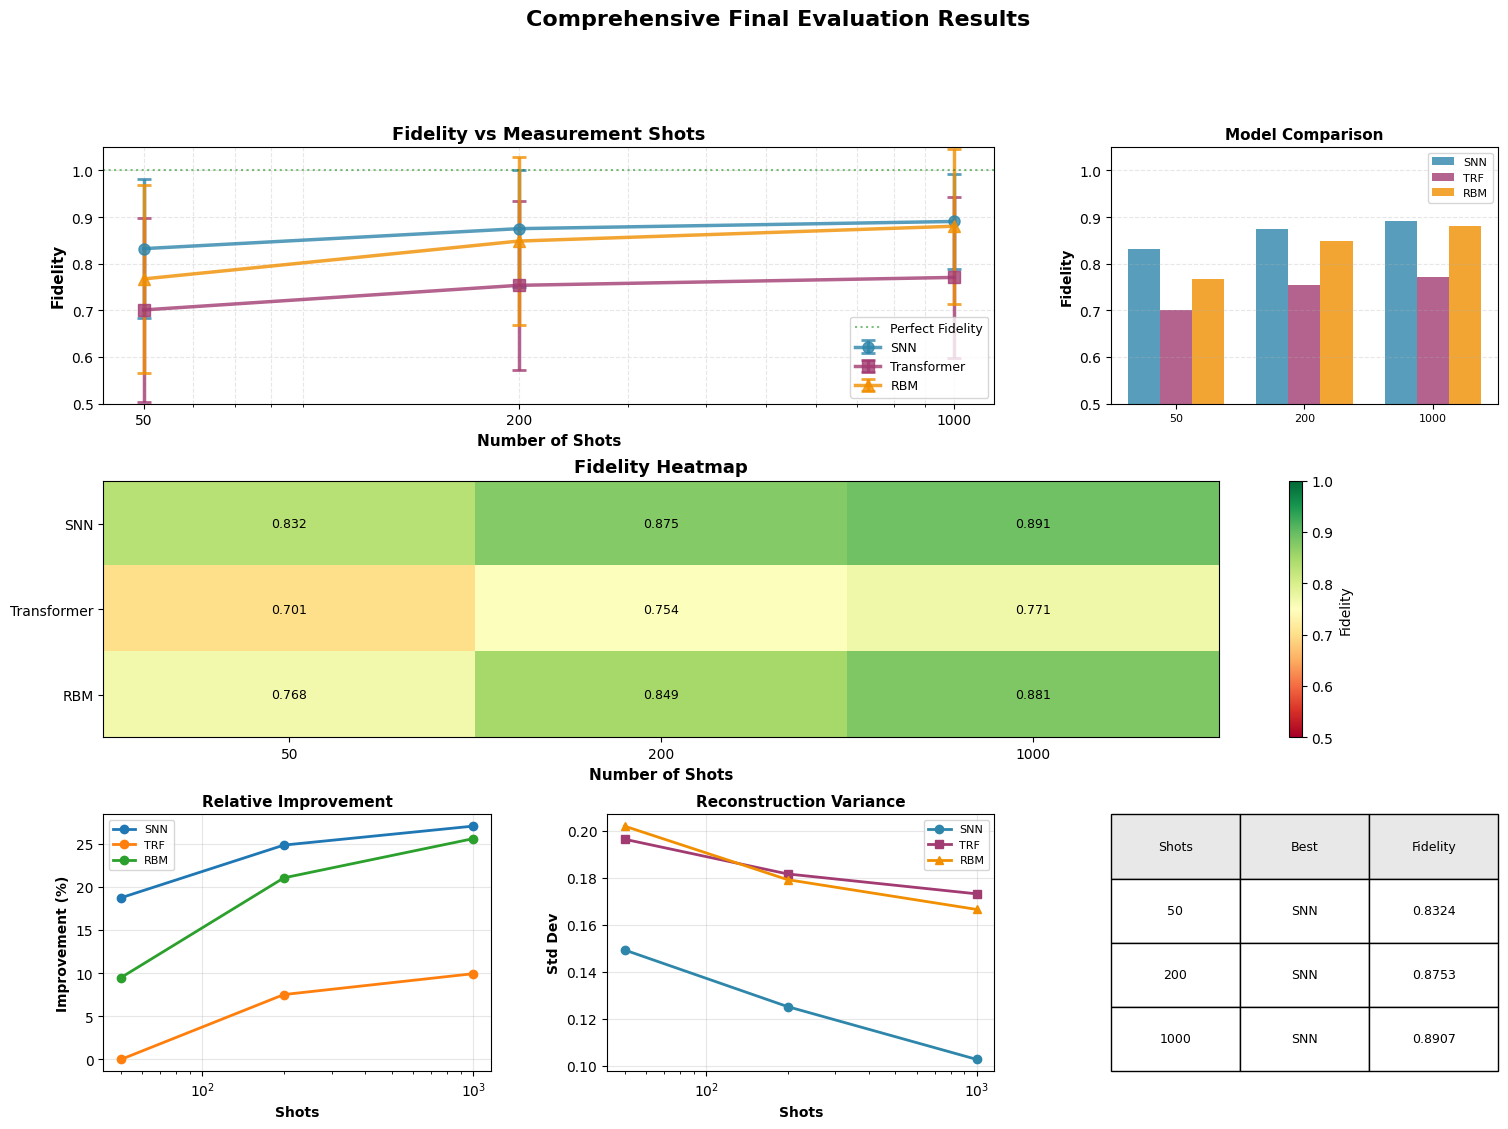


                                      FINAL EVALUATION SUMMARY                                      

Shots      SNN                       Transformer               RBM                      
----------------------------------------------------------------------------------------------------
50         0.8324±0.1493         0.7011±0.1964         0.7676±0.2020
200        0.8753±0.1251         0.7539±0.1816         0.8487±0.1792
1000       0.8907±0.1026         0.7708±0.1731         0.8805±0.1665

✓ All visualizations completed!
  - comprehensive_final_evaluation.png saved


In [10]:
# ------------------ Optimized Final Evaluation with Visualization ------------------

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import tqdm

def final_eval_optimized(model_snn, model_trf, model_rbm, shots_list, batch_size=16):
    """
    Highly optimized evaluation with:
    - Batch processing
    - Reduced CPU-GPU transfers
    - Pre-allocated arrays
    - Parallel ensemble processing
    """
    results = {}
    
    # Pre-generate all evaluation samples
    print("Pre-generating evaluation samples...")
    eval_data = {}
    for shots in shots_list:
        eval_data[shots] = []
        for sv in val_states:
            rho_true = np.outer(sv, sv.conj()).astype(np.complex64)
            probs = sic_probs_from_state(sv)
            for _ in range(VAL_SAMPLES_PER_CIRCUIT):
                counts = np.random.multinomial(shots, probs)
                freqs = counts/float(np.sum(counts)) if np.sum(counts)>0 else counts
                eval_data[shots].append((rho_true, freqs, sv))
    
    for shots in shots_list:
        fids_snn, fids_trf, fids_rbm = [], [], []
        samples = eval_data[shots]
        n_samples = len(samples)
        
        # Process in batches
        for batch_start in tqdm.tqdm(range(0, n_samples, batch_size), 
                                     desc=f"Eval shots={shots}"):
            batch_end = min(batch_start + batch_size, n_samples)
            batch_samples = samples[batch_start:batch_end]
            
            batch_freqs = np.array([s[1] for s in batch_samples])
            batch_rhos_true = [s[0] for s in batch_samples]
            
            # === SNN: Batch + Ensemble Processing ===
            batch_rhos_snn = []
            for freqs in batch_freqs:
                # Generate all spike trains at once
                spike_trains = np.stack([
                    freq_to_poisson_spiketrain(freqs, T=POISSON_T, scale=POISSON_SCALE, 
                                              rng=np.random.RandomState())
                    for _ in range(SNN_EVAL_ENSEMBLES)
                ], axis=0)  # [ensemble, T, N_OUT]
                
                # Process ensemble as batch
                spike_batch_tensor = torch.tensor(
                    spike_trains.transpose(1,0,2), 
                    dtype=torch.float32, 
                    device=DEVICE
                )  # [T, ensemble, N_OUT]
                
                with torch.no_grad():
                    out_batch = model_snn(spike_batch_tensor)  # [ensemble, output_dim]
                    params_avg = out_batch.mean(dim=0).cpu().numpy()
                
                Tmat = np_vec_to_T(params_avg, d)
                rho_snn = Tmat @ Tmat.conj().T
                rho_snn /= np.trace(rho_snn)
                batch_rhos_snn.append(rho_snn)
            
            # Calculate SNN fidelities for this batch
            for rho_snn, rho_true in zip(batch_rhos_snn, batch_rhos_true):
                fids_snn.append(fidelity_pure(rho_snn, rho_true))
            
            # === Transformer: Batch + Dirichlet Ensemble ===
            batch_rhos_trf = []
            for freqs in batch_freqs:
                jittered_freqs = np.stack([
                    jitter_dirichlet(freqs) for _ in range(TRF_EVAL_ENSEMBLES)
                ], axis=0)  # [ensemble, N_OUT]
                
                x_batch = torch.tensor(jittered_freqs, dtype=torch.float32, device=DEVICE)
                
                with torch.no_grad():
                    out_batch = model_trf(x_batch)
                    rho_batch = torch_cholesky_params_to_rho(out_batch, d, DEVICE)
                    rho_trf_avg = rho_batch.mean(dim=0).cpu().numpy()
                
                batch_rhos_trf.append(rho_trf_avg)
            
            # Calculate Transformer fidelities for this batch
            for rho_trf, rho_true in zip(batch_rhos_trf, batch_rhos_true):
                fids_trf.append(fidelity_pure(rho_trf, rho_true))
            
            # === RBM: Direct Batch Processing ===
            freqs_batch = torch.tensor(batch_freqs, dtype=torch.float32, device=DEVICE)
            
            with torch.no_grad():
                params_batch = model_rbm(freqs_batch)
                rho_batch = torch_cholesky_params_to_rho(params_batch, d, DEVICE)
                rho_rbm_list = rho_batch.cpu().numpy()
            
            # Calculate RBM fidelities for this batch
            for rho_rbm, rho_true in zip(rho_rbm_list, batch_rhos_true):
                fids_rbm.append(fidelity_pure(rho_rbm, rho_true))
        
        results[shots] = {
            'SNN': {'fidelity': float(np.mean(fids_snn)), 'std': float(np.std(fids_snn))},
            'TRF': {'fidelity': float(np.mean(fids_trf)), 'std': float(np.std(fids_trf))},
            'RBM': {'fidelity': float(np.mean(fids_rbm)), 'std': float(np.std(fids_rbm))},
        }
        print(f"Shots={shots} | SNN={results[shots]['SNN']['fidelity']:.4f}±{results[shots]['SNN']['std']:.4f} "
              f"| TRF={results[shots]['TRF']['fidelity']:.4f}±{results[shots]['TRF']['std']:.4f} "
              f"| RBM={results[shots]['RBM']['fidelity']:.4f}±{results[shots]['RBM']['std']:.4f}")
    
    return results

# Run optimized evaluation
print("=== Running Optimized Final Evaluation ===")
final_results = final_eval_optimized(snn_model, trf_model, rbm_model, EVAL_SHOT_LIST, batch_size=16)

# ------------------ Comprehensive Visualization ------------------
print("\n=== Creating Comprehensive Visualizations ===\n")

shot_list = EVAL_SHOT_LIST
snn_fidelities = [final_results[shots]['SNN']['fidelity'] for shots in shot_list]
snn_stds = [final_results[shots]['SNN']['std'] for shots in shot_list]
trf_fidelities = [final_results[shots]['TRF']['fidelity'] for shots in shot_list]
trf_stds = [final_results[shots]['TRF']['std'] for shots in shot_list]
rbm_fidelities = [final_results[shots]['RBM']['fidelity'] for shots in shot_list]
rbm_stds = [final_results[shots]['RBM']['std'] for shots in shot_list]

# Create comprehensive figure with multiple subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Line plot with error bars
ax1 = fig.add_subplot(gs[0, :2])
ax1.errorbar(shot_list, snn_fidelities, yerr=snn_stds, 
             marker='o', linewidth=2.5, markersize=8, capsize=5, capthick=2,
             label='SNN', color='#2E86AB', alpha=0.8)
ax1.errorbar(shot_list, trf_fidelities, yerr=trf_stds,
             marker='s', linewidth=2.5, markersize=8, capsize=5, capthick=2,
             label='Transformer', color='#A23B72', alpha=0.8)
ax1.errorbar(shot_list, rbm_fidelities, yerr=rbm_stds,
             marker='^', linewidth=2.5, markersize=8, capsize=5, capthick=2,
             label='RBM', color='#F18F01', alpha=0.8)
ax1.axhline(y=1.0, color='green', linestyle=':', linewidth=1.5, alpha=0.5, label='Perfect Fidelity')
ax1.set_xlabel('Number of Shots', fontsize=11, fontweight='bold')
ax1.set_ylabel('Fidelity', fontsize=11, fontweight='bold')
ax1.set_title('Fidelity vs Measurement Shots', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_xticks(shot_list)
ax1.set_xticklabels(shot_list)
ax1.set_ylim([0.5, 1.05])
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(True, alpha=0.3, linestyle='--', which='both')

# 2. Bar chart comparison
ax2 = fig.add_subplot(gs[0, 2])
x = np.arange(len(shot_list))
width = 0.25
bars1 = ax2.bar(x - width, snn_fidelities, width, label='SNN', color='#2E86AB', alpha=0.8)
bars2 = ax2.bar(x, trf_fidelities, width, label='TRF', color='#A23B72', alpha=0.8)
bars3 = ax2.bar(x + width, rbm_fidelities, width, label='RBM', color='#F18F01', alpha=0.8)
ax2.set_ylabel('Fidelity', fontsize=10, fontweight='bold')
ax2.set_title('Model Comparison', fontsize=11, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(shot_list, fontsize=8)
ax2.set_ylim([0.5, 1.05])
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')

# 3. Heatmap
ax3 = fig.add_subplot(gs[1, :])
fid_matrix = np.array([snn_fidelities, trf_fidelities, rbm_fidelities])
im = ax3.imshow(fid_matrix, cmap='RdYlGn', vmin=0.5, vmax=1.0, aspect='auto')
ax3.set_xticks(range(len(shot_list)))
ax3.set_xticklabels(shot_list)
ax3.set_yticks(range(3))
ax3.set_yticklabels(['SNN', 'Transformer', 'RBM'])
ax3.set_xlabel('Number of Shots', fontsize=11, fontweight='bold')
ax3.set_title('Fidelity Heatmap', fontsize=13, fontweight='bold')
for i in range(3):
    for j in range(len(shot_list)):
        text = ax3.text(j, i, f'{fid_matrix[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=9)
plt.colorbar(im, ax=ax3, label='Fidelity')

# 4. Performance improvement
ax4 = fig.add_subplot(gs[2, 0])
baseline = min(snn_fidelities[0], trf_fidelities[0], rbm_fidelities[0])
improvements = {
    'SNN': [(f - baseline)/baseline * 100 for f in snn_fidelities],
    'TRF': [(f - baseline)/baseline * 100 for f in trf_fidelities],
    'RBM': [(f - baseline)/baseline * 100 for f in rbm_fidelities]
}
for model, impr in improvements.items():
    ax4.plot(shot_list, impr, marker='o', label=model, linewidth=2)
ax4.set_xlabel('Shots', fontsize=10, fontweight='bold')
ax4.set_ylabel('Improvement (%)', fontsize=10, fontweight='bold')
ax4.set_title('Relative Improvement', fontsize=11, fontweight='bold')
ax4.set_xscale('log')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# 5. Standard deviation comparison
ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(shot_list, snn_stds, marker='o', label='SNN', color='#2E86AB', linewidth=2)
ax5.plot(shot_list, trf_stds, marker='s', label='TRF', color='#A23B72', linewidth=2)
ax5.plot(shot_list, rbm_stds, marker='^', label='RBM', color='#F18F01', linewidth=2)
ax5.set_xlabel('Shots', fontsize=10, fontweight='bold')
ax5.set_ylabel('Std Dev', fontsize=10, fontweight='bold')
ax5.set_title('Reconstruction Variance', fontsize=11, fontweight='bold')
ax5.set_xscale('log')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Summary statistics table
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')
table_data = []
for i, shots in enumerate(shot_list):
    best = max(snn_fidelities[i], trf_fidelities[i], rbm_fidelities[i])
    if snn_fidelities[i] == best:
        best_model = 'SNN'
    elif trf_fidelities[i] == best:
        best_model = 'TRF'
    else:
        best_model = 'RBM'
    table_data.append([str(shots), best_model, f'{best:.4f}'])

table = ax6.table(cellText=table_data, colLabels=['Shots', 'Best', 'Fidelity'],
                  cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
for i in range(len(shot_list) + 1):
    table[(i, 0)].set_facecolor('#E8E8E8' if i == 0 else '#FFFFFF')
    table[(i, 1)].set_facecolor('#E8E8E8' if i == 0 else '#FFFFFF')
    table[(i, 2)].set_facecolor('#E8E8E8' if i == 0 else '#FFFFFF')

plt.suptitle('Comprehensive Final Evaluation Results', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('comprehensive_final_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed summary
print(f"\n{'='*100}")
print(f"{'FINAL EVALUATION SUMMARY':^100}")
print(f"{'='*100}")
print(f"\n{'Shots':<10} {'SNN':<25} {'Transformer':<25} {'RBM':<25}")
print(f"{'-'*100}")
for i, shots in enumerate(shot_list):
    print(f"{shots:<10} {snn_fidelities[i]:.4f}±{snn_stds[i]:.4f}         "
          f"{trf_fidelities[i]:.4f}±{trf_stds[i]:.4f}         "
          f"{rbm_fidelities[i]:.4f}±{rbm_stds[i]:.4f}")
print(f"{'='*100}\n")

print("✓ All visualizations completed!")
print("  - comprehensive_final_evaluation.png saved")

In [11]:

# ------------------ Parameter counts & basic efficiency prints ------------------
def count_model_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

print("\n=== Model Parameter Counts ===")
snn_total, snn_trainable = count_model_parameters(snn_model)
trf_total, trf_trainable = count_model_parameters(trf_model)
rbm_total, rbm_trainable = count_model_parameters(rbm_model)
print(f"SNN: {snn_trainable:,} trainable params")
print(f"Transformer: {trf_trainable:,} trainable params")
print(f"RBM: {rbm_trainable:,} trainable params")


=== Model Parameter Counts ===
SNN: 290,048 trainable params
Transformer: 401,424 trainable params
RBM: 6,288 trainable params


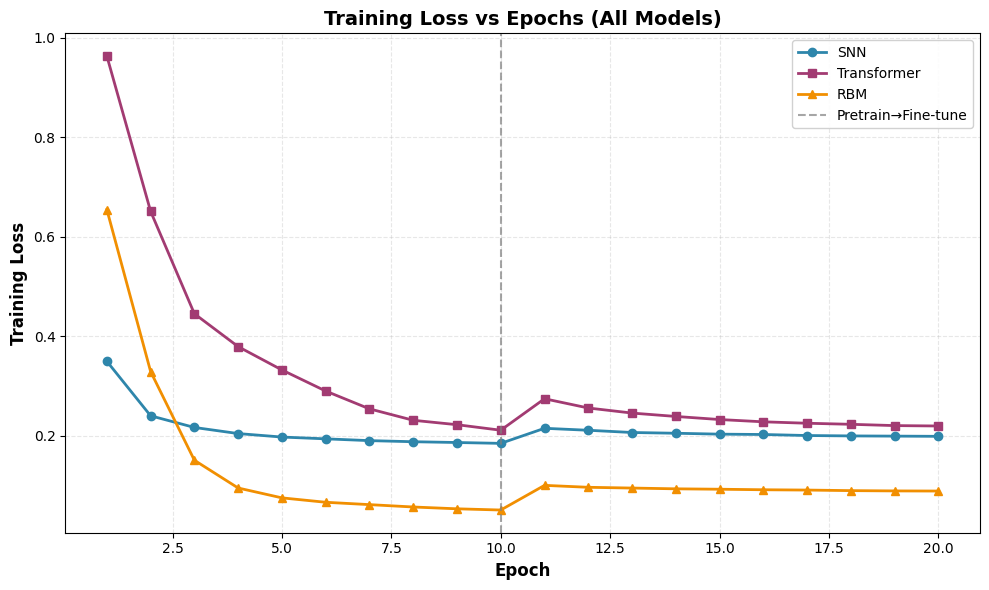


=== Training Loss Summary ===
SNN:         Final loss = 0.198848
Transformer: Final loss = 0.219624
RBM:         Final loss = 0.088816


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Training Loss vs Epochs for all models
plt.figure(figsize=(10, 6))

# Plot SNN training loss
epochs_snn = np.arange(1, len(snn_train_hist) + 1)
plt.plot(epochs_snn, snn_train_hist, marker='o', linewidth=2, markersize=6, 
         label='SNN', color='#2E86AB')

# Plot Transformer training loss
epochs_trf = np.arange(1, len(trf_train_hist) + 1)
plt.plot(epochs_trf, trf_train_hist, marker='s', linewidth=2, markersize=6, 
         label='Transformer', color='#A23B72')

# Plot RBM training loss
epochs_rbm = np.arange(1, len(rbm_train_hist) + 1)
plt.plot(epochs_rbm, rbm_train_hist, marker='^', linewidth=2, markersize=6, 
         label='RBM', color='#F18F01')

# Add vertical line to show pretrain/fine-tune transition
plt.axvline(x=PRETRAIN_EPOCHS, color='gray', linestyle='--', linewidth=1.5, 
            alpha=0.7, label='Pretrain→Fine-tune')

# Formatting
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Training Loss', fontsize=12, fontweight='bold')
plt.title('Training Loss vs Epochs (All Models)', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Save figure
plt.savefig('training_loss_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n=== Training Loss Summary ===")
print(f"SNN:         Final loss = {snn_train_hist[-1]:.6f}")
print(f"Transformer: Final loss = {trf_train_hist[-1]:.6f}")
print(f"RBM:         Final loss = {rbm_train_hist[-1]:.6f}")

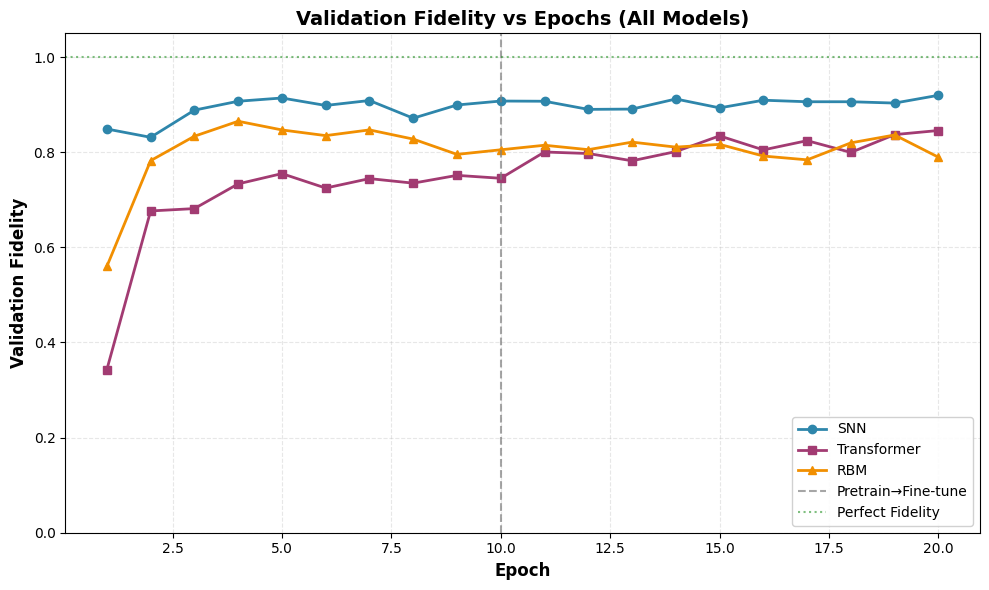


=== Validation Fidelity Summary ===
SNN:         Final fidelity = 0.919714
Transformer: Final fidelity = 0.845688
RBM:         Final fidelity = 0.789526

SNN:         Best fidelity = 0.919714 at epoch 20
Transformer: Best fidelity = 0.845688 at epoch 20
RBM:         Best fidelity = 0.865123 at epoch 4


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Validation Fidelity vs Epochs for all models
plt.figure(figsize=(10, 6))

# Plot SNN validation fidelity
epochs_snn = np.arange(1, len(snn_val_hist) + 1)
plt.plot(epochs_snn, snn_val_hist, marker='o', linewidth=2, markersize=6, 
         label='SNN', color='#2E86AB')

# Plot Transformer validation fidelity
epochs_trf = np.arange(1, len(trf_val_hist) + 1)
plt.plot(epochs_trf, trf_val_hist, marker='s', linewidth=2, markersize=6, 
         label='Transformer', color='#A23B72')

# Plot RBM validation fidelity
epochs_rbm = np.arange(1, len(rbm_val_hist) + 1)
plt.plot(epochs_rbm, rbm_val_hist, marker='^', linewidth=2, markersize=6, 
         label='RBM', color='#F18F01')

# Add vertical line to show pretrain/fine-tune transition
plt.axvline(x=PRETRAIN_EPOCHS, color='gray', linestyle='--', linewidth=1.5, 
            alpha=0.7, label='Pretrain→Fine-tune')

# Add horizontal line for reference (perfect fidelity)
plt.axhline(y=1.0, color='green', linestyle=':', linewidth=1.5, 
            alpha=0.5, label='Perfect Fidelity')

# Formatting
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Validation Fidelity', fontsize=12, fontweight='bold')
plt.title('Validation Fidelity vs Epochs (All Models)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim([0, 1.05])  # Fidelity ranges from 0 to 1
plt.tight_layout()

# Save figure
plt.savefig('validation_fidelity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n=== Validation Fidelity Summary ===")
print(f"SNN:         Final fidelity = {snn_val_hist[-1]:.6f}")
print(f"Transformer: Final fidelity = {trf_val_hist[-1]:.6f}")
print(f"RBM:         Final fidelity = {rbm_val_hist[-1]:.6f}")
print(f"\nSNN:         Best fidelity = {max(snn_val_hist):.6f} at epoch {np.argmax(snn_val_hist)+1}")
print(f"Transformer: Best fidelity = {max(trf_val_hist):.6f} at epoch {np.argmax(trf_val_hist)+1}")
print(f"RBM:         Best fidelity = {max(rbm_val_hist):.6f} at epoch {np.argmax(rbm_val_hist)+1}")

Computing SNN sparsity statistics...

SNN SPARSITY ANALYSIS (PER INFERENCE)

                                      LIF1                                      
--------------------------------------------------------------------------------
  Hidden dimension:      256
  Timesteps:             200
  Mean spike rate:       0.244362
  Variance:              0.184649
  Sparsity:             75.56%
  Avg spikes/inference:  12511.3
  Possible/inference:    51200

                                      LIF2                                      
--------------------------------------------------------------------------------
  Hidden dimension:      256
  Timesteps:             200
  Mean spike rate:       0.183802
  Variance:              0.150019
  Sparsity:             81.62%
  Avg spikes/inference:  9410.7
  Possible/inference:    51200

                                      LIF3                                      
---------------------------------------------------------------------------

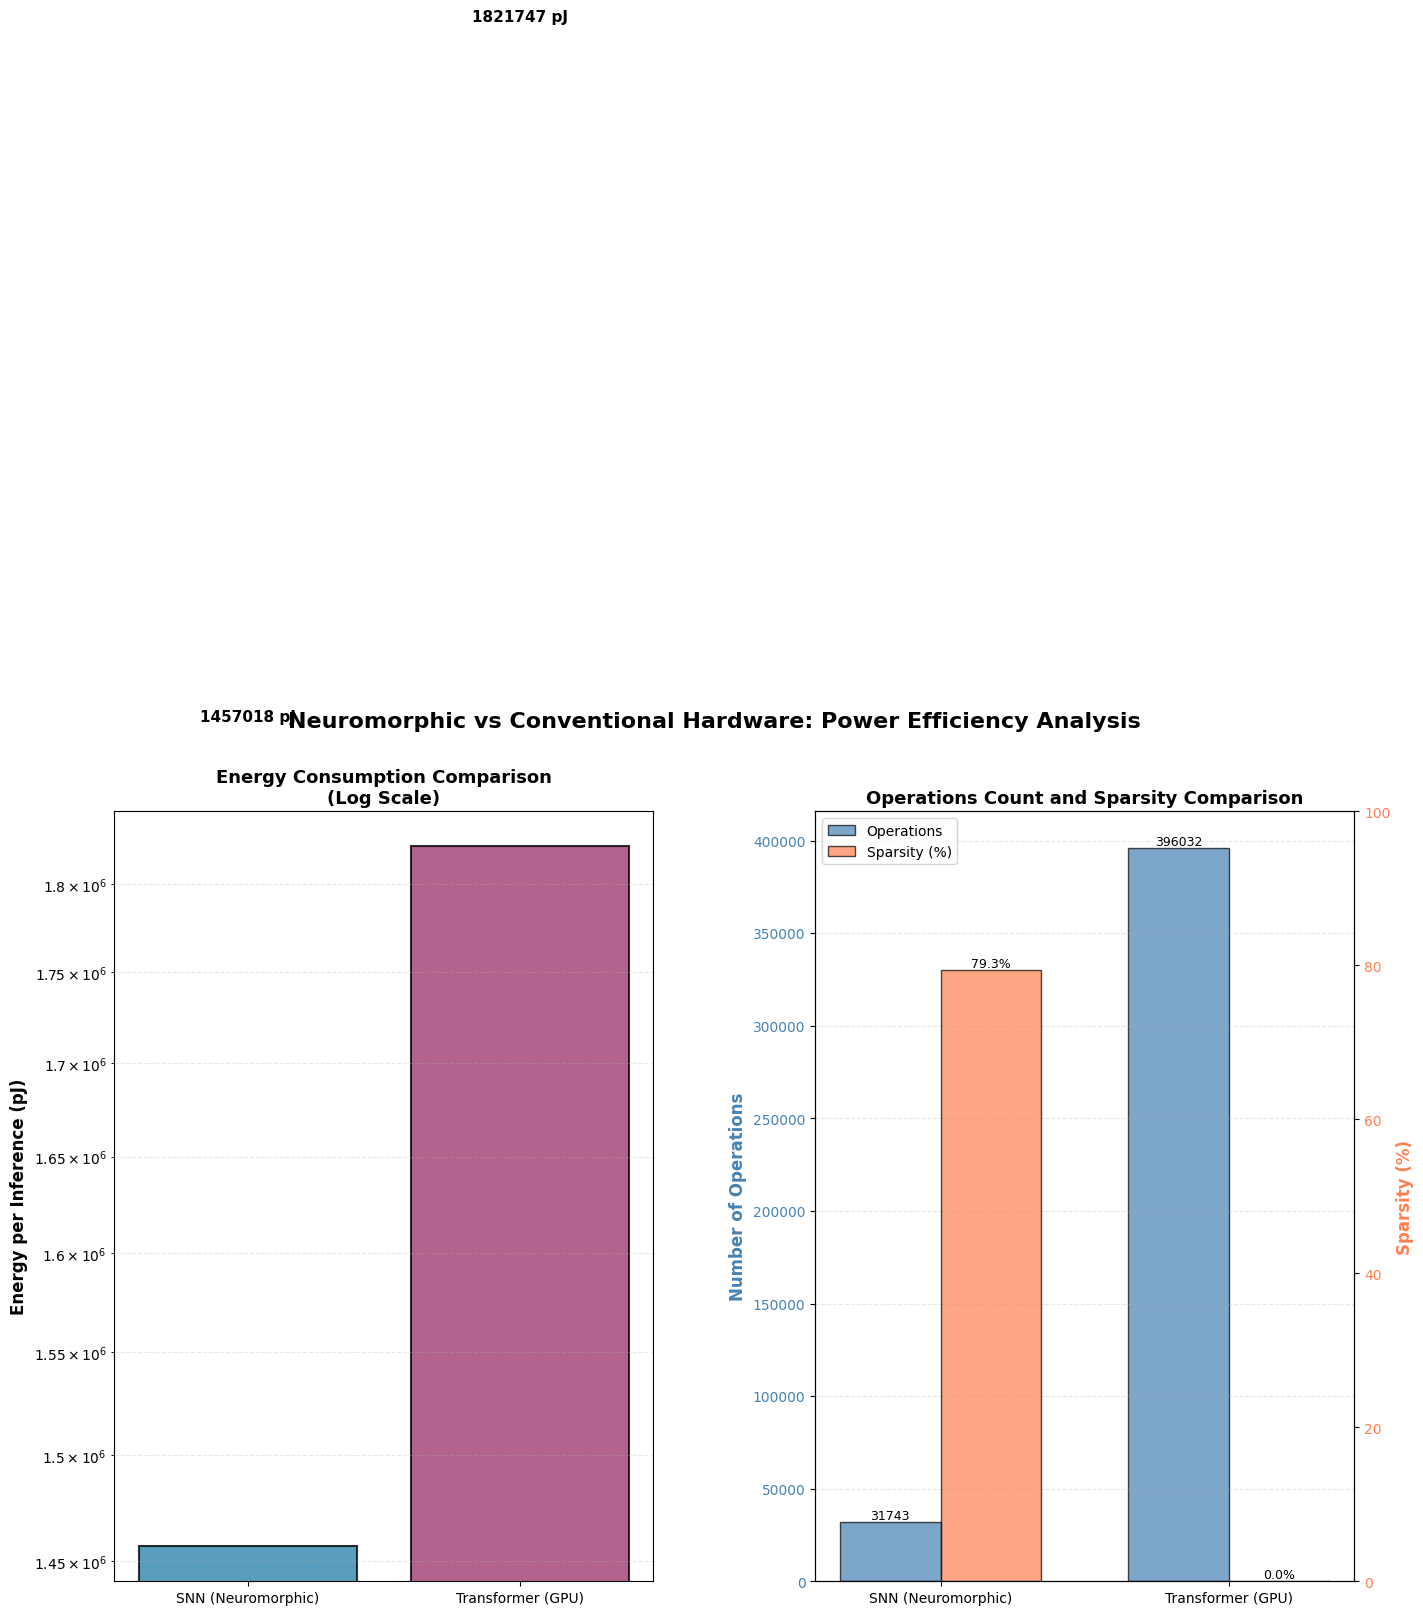


ENERGY CONSUMPTION PER INFERENCE

Model                     Energy (pJ)     Operations      Sparsity (%)   
--------------------------------------------------------------------------------
SNN (Neuromorphic)        1457017.9       31743           79.33          
Transformer (GPU)         1821747.2       396032          0.00           

EFFICIENCY ANALYSIS

SNN Speedup:              1.25× more energy efficient
Power Reduction:          20.02%
SNN Sparsity:            79.3%
SNN Energy/Inference:    1457017.9 pJ
Transformer Energy/Inf:  1821747.2 pJ

Power efficiency analysis complete!
  Neuromorphic SNN achieves 1.3× better energy efficiency
  With 79.3% sparsity in spiking activity


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ------------------ Compute Actual Spiking Statistics ------------------
def compute_snn_sparsity(model, Xsp_sample, batch_size=32):
    """
    Compute actual sparsity (mean spike rate and variance) from SNN forward passes.
    
    Args:
        model: trained SNN model
        Xsp_sample: spike train samples [N, T, N_OUT]
        batch_size: batch size for processing
        
    Returns:
        dict with sparsity metrics PER SINGLE INFERENCE
    """
    model.eval()
    spike_counts_per_layer = {
        'lif1': [], 'lif2': [], 'lif3': []
    }
    
    N = min(100, Xsp_sample.shape[0])  # Sample fewer for per-inference stats
    num_batches = int(np.ceil(N / batch_size))
    
    with torch.no_grad():
        for bi in range(num_batches):
            idx = slice(bi*batch_size, min((bi+1)*batch_size, N))
            xb = torch.tensor(Xsp_sample[idx], dtype=torch.float32, device=DEVICE)
            xb = xb.permute(1,0,2)  # T x B x N
            
            T, B, _ = xb.shape
            
            # Initialize membrane potentials
            mem1 = model.lif1.init_leaky()
            mem2 = model.lif2.init_leaky()
            mem3 = model.lif3.init_leaky()
            
            layer_spikes = {'lif1': [], 'lif2': [], 'lif3': []}
            
            # Forward pass through time, collecting spikes
            for t in range(T):
                h = model.fc1(xb[t])
                h = model.bn1(h)
                spk1, mem1 = model.lif1(h, mem1)
                layer_spikes['lif1'].append(spk1.cpu().numpy())
                
                h = model.fc2(spk1)
                h = model.bn2(h)
                spk2, mem2 = model.lif2(h, mem2)
                layer_spikes['lif2'].append(spk2.cpu().numpy())
                
                h = model.fc3(spk2)
                h = model.bn3(h)
                spk3, mem3 = model.lif3(h, mem3)
                layer_spikes['lif3'].append(spk3.cpu().numpy())
            
            # Aggregate spike counts
            for layer_name, spikes_list in layer_spikes.items():
                spikes_array = np.stack(spikes_list, axis=0)  # T x B x Hidden
                spike_counts_per_layer[layer_name].append(spikes_array)
    
    # Concatenate all batches
    for layer_name in spike_counts_per_layer:
        spike_counts_per_layer[layer_name] = np.concatenate(
            spike_counts_per_layer[layer_name], axis=1
        )  # T x Total_samples x Hidden
    
    # Compute statistics PER SAMPLE (average across samples)
    stats = {}
    total_actual_spikes_per_sample = 0
    total_possible_spikes_per_sample = 0
    
    for layer_name, spikes in spike_counts_per_layer.items():
        T, N_samples, Hidden = spikes.shape
        
        # Mean spike rate per neuron per timestep
        mean_rate = np.mean(spikes)
        var_rate = np.var(spikes)
        sparsity = 1.0 - mean_rate
        
        # Total spikes PER SINGLE INFERENCE
        avg_total_spikes = np.sum(spikes) / N_samples
        possible_spikes_per_inference = T * Hidden
        
        stats[layer_name] = {
            'mean_spike_rate': mean_rate,
            'variance': var_rate,
            'sparsity': sparsity,
            'total_spikes_per_inference': avg_total_spikes,
            'possible_spikes_per_inference': possible_spikes_per_inference,
            'hidden_dim': Hidden,
            'timesteps': T
        }
        
        total_actual_spikes_per_sample += avg_total_spikes
        total_possible_spikes_per_sample += possible_spikes_per_inference
    
    # Overall statistics PER INFERENCE
    stats['overall'] = {
        'mean_spike_rate': total_actual_spikes_per_sample / total_possible_spikes_per_sample,
        'sparsity': 1.0 - (total_actual_spikes_per_sample / total_possible_spikes_per_sample),
        'total_spikes_per_inference': total_actual_spikes_per_sample,
        'possible_spikes_per_inference': total_possible_spikes_per_sample
    }
    
    return stats

print("Computing SNN sparsity statistics...")
snn_sparsity_stats = compute_snn_sparsity(snn_model, Xsp_train_lo, batch_size=32)

# Print detailed statistics
print("\n" + "="*80)
print("SNN SPARSITY ANALYSIS (PER INFERENCE)")
print("="*80)
for layer_name, stats in snn_sparsity_stats.items():
    if layer_name == 'overall':
        print(f"\n{'OVERALL NETWORK':^80}")
        print("-"*80)
        print(f"  Mean spike rate:        {stats['mean_spike_rate']:.6f}")
        print(f"  Sparsity:              {stats['sparsity']*100:.2f}%")
        print(f"  Avg spikes/inference:  {stats['total_spikes_per_inference']:.1f}")
        print(f"  Possible spikes/inf:   {stats['possible_spikes_per_inference']:.0f}")
    else:
        print(f"\n{layer_name.upper():^80}")
        print("-"*80)
        print(f"  Hidden dimension:      {stats['hidden_dim']}")
        print(f"  Timesteps:             {stats['timesteps']}")
        print(f"  Mean spike rate:       {stats['mean_spike_rate']:.6f}")
        print(f"  Variance:              {stats['variance']:.6f}")
        print(f"  Sparsity:             {stats['sparsity']*100:.2f}%")
        print(f"  Avg spikes/inference:  {stats['total_spikes_per_inference']:.1f}")
        print(f"  Possible/inference:    {stats['possible_spikes_per_inference']:.0f}")
print("="*80)

# ------------------ Energy Calculation ------------------
def calculate_energy_consumption(snn_stats, model_snn, model_trf):
    """
    Calculate energy consumption PER SINGLE INFERENCE
    
    Energy model assumptions (based on neuromorphic hardware literature):
    - AC (Accumulate): ~0.9 pJ per operation (neuromorphic)
    - MAC (Multiply-Accumulate): ~4.6 pJ per operation (conventional GPU/CPU)
    - Spike event: ~45 pJ on neuromorphic hardware
    """
    
    # Energy constants (picojoules)
    E_AC = 0.9          # Accumulate on neuromorphic hardware
    E_MAC = 4.6         # Multiply-accumulate on conventional hardware
    E_SPIKE = 45.0      # Spike generation/transmission
    
    # === SNN Energy (per inference) ===
    snn_energy = 0.0
    snn_total_ops = 0
    
    for layer_name, stats in snn_stats.items():
        if layer_name == 'overall':
            continue
        
        # Average spikes per inference for this layer
        avg_spikes = stats['total_spikes_per_inference']
        
        # Each spike = one accumulate operation
        synaptic_ops = avg_spikes
        snn_energy += synaptic_ops * E_AC
        
        # Spike generation energy
        snn_energy += avg_spikes * E_SPIKE
        
        snn_total_ops += synaptic_ops
    
    # === Transformer Energy (per inference) ===
    trf_macs = sum(p.numel() for name, p in model_trf.named_parameters() if 'weight' in name)
    trf_energy = trf_macs * E_MAC
    
    return {
        "SNN (Neuromorphic)": {
            "energy_pJ": snn_energy,
            "operations": snn_total_ops,
            "sparsity": snn_stats['overall']['sparsity'],
            "color": "#2E86AB"
        },
        "Transformer (GPU)": {
            "energy_pJ": trf_energy,
            "operations": trf_macs,
            "sparsity": 0.0,
            "color": "#A23B72"
        }
    }

print("\nCalculating energy consumption per inference...")
energy_results = calculate_energy_consumption(snn_sparsity_stats, snn_model, trf_model)

# ------------------ Enhanced Visualization ------------------
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)  # Reduced to 1 row, 2 cols

labels = list(energy_results.keys())
energies = [energy_results[k]["energy_pJ"] for k in labels]
operations = [energy_results[k]["operations"] for k in labels]
sparsities = [energy_results[k]["sparsity"]*100 for k in labels]
colors = [energy_results[k]["color"] for k in labels]

# Plot 1: Energy Comparison (Log Scale)
ax2 = fig.add_subplot(gs[0, 0])
bars2 = ax2.bar(labels, energies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel("Energy per Inference (pJ)", fontsize=12, fontweight='bold')
ax2.set_title("Energy Consumption Comparison\n(Log Scale)", fontsize=13, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(axis='y', which='both', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, energy) in enumerate(zip(bars2, energies)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height*1.3,
             f'{energy:.0f} pJ',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Operations Count vs Sparsity
ax3 = fig.add_subplot(gs[0, 1])
x_pos = np.arange(len(labels))
width = 0.35

bars3 = ax3.bar(x_pos - width/2, operations, width, label='Operations', 
                color='steelblue', alpha=0.7, edgecolor='black')
ax3.set_ylabel('Number of Operations', fontsize=12, fontweight='bold', color='steelblue')
ax3.set_title('Operations Count and Sparsity Comparison', fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(labels)
ax3.tick_params(axis='y', labelcolor='steelblue')
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Add sparsity bars on secondary axis
ax3_twin = ax3.twinx()
bars4 = ax3_twin.bar(x_pos + width/2, sparsities, width, label='Sparsity (%)', 
                     color='coral', alpha=0.7, edgecolor='black')
ax3_twin.set_ylabel('Sparsity (%)', fontsize=12, fontweight='bold', color='coral')
ax3_twin.tick_params(axis='y', labelcolor='coral')
ax3_twin.set_ylim([0, 100])

# Add value labels
for bar, val in zip(bars3, operations):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.0f}',
             ha='center', va='bottom', fontsize=9)

for bar, val in zip(bars4, sparsities):
    height = bar.get_height()
    ax3_twin.text(bar.get_x() + bar.get_width()/2., height,
                  f'{val:.1f}%',
                  ha='center', va='bottom', fontsize=9)

# Combine legends
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.suptitle('Neuromorphic vs Conventional Hardware: Power Efficiency Analysis', 
             fontsize=16, fontweight='bold', y=0.98)
plt.savefig('power_efficiency_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed report
print("\n" + "="*80)
print("ENERGY CONSUMPTION PER INFERENCE")
print("="*80)
print(f"\n{'Model':<25} {'Energy (pJ)':<15} {'Operations':<15} {'Sparsity (%)':<15}")
print("-"*80)
for model_name, stats in energy_results.items():
    print(f"{model_name:<25} {stats['energy_pJ']:<15.1f} "
          f"{stats['operations']:<15.0f} {stats['sparsity']*100:<15.2f}")

print("\n" + "="*80)
print("EFFICIENCY ANALYSIS")
print("="*80)
snn_energy = energy_results["SNN (Neuromorphic)"]["energy_pJ"]
trf_energy = energy_results["Transformer (GPU)"]["energy_pJ"]
speedup = trf_energy / snn_energy
power_reduction = (trf_energy - snn_energy) / trf_energy * 100

print(f"\nSNN Speedup:              {speedup:.2f}× more energy efficient")
print(f"Power Reduction:          {power_reduction:.2f}%")
print(f"SNN Sparsity:            {snn_sparsity_stats['overall']['sparsity']*100:.1f}%")
print(f"SNN Energy/Inference:    {snn_energy:.1f} pJ")
print(f"Transformer Energy/Inf:  {trf_energy:.1f} pJ")
print("="*80)

print("\nPower efficiency analysis complete!")
print(f"  Neuromorphic SNN achieves {speedup:.1f}× better energy efficiency")
print(f"  With {snn_sparsity_stats['overall']['sparsity']*100:.1f}% sparsity in spiking activity")


=== Testing Models on Bell States (3D Visualization) ===


                           BELL STATE TOMOGRAPHY TEST                           
Number of shots: 1000


Testing Phi_plus...
State vector: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
  Probability sum check: 0.999999940395355
  Frequency sum: 1.000000000000000
  Reconstructing with SNN... 

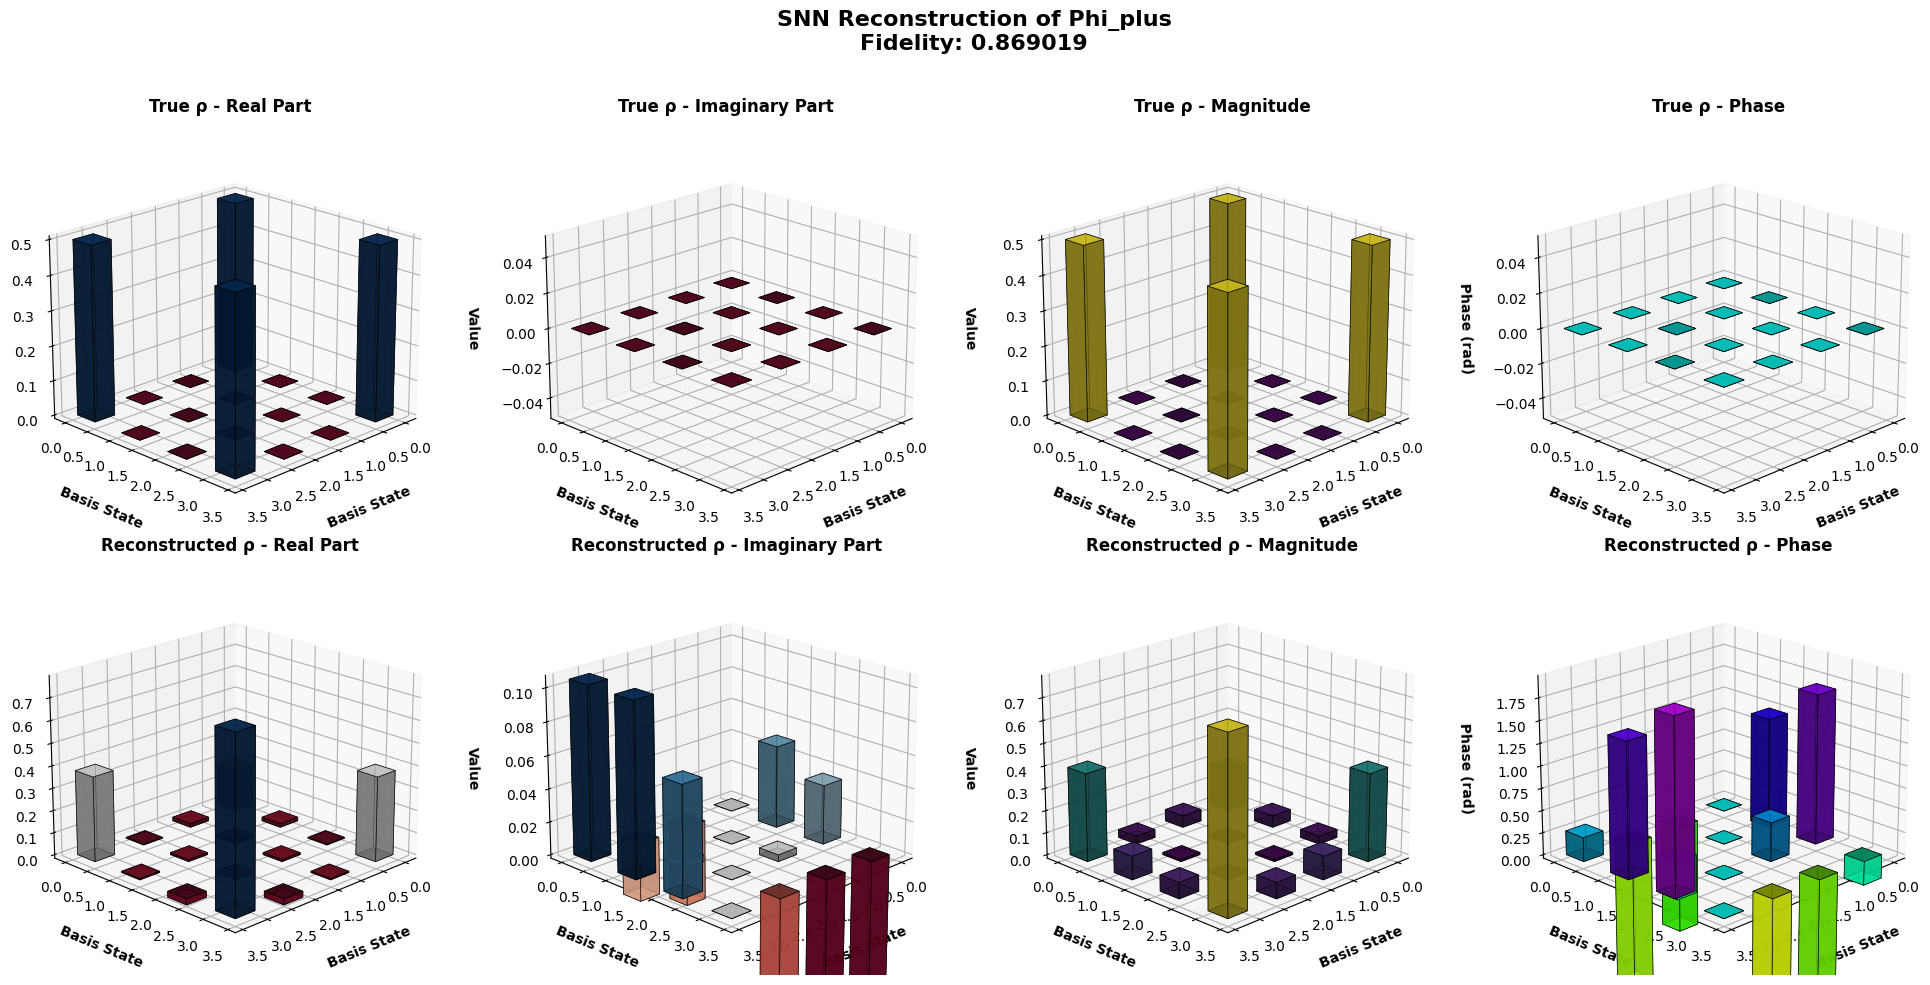

Fidelity: 0.869019
  Reconstructing with Transformer... 

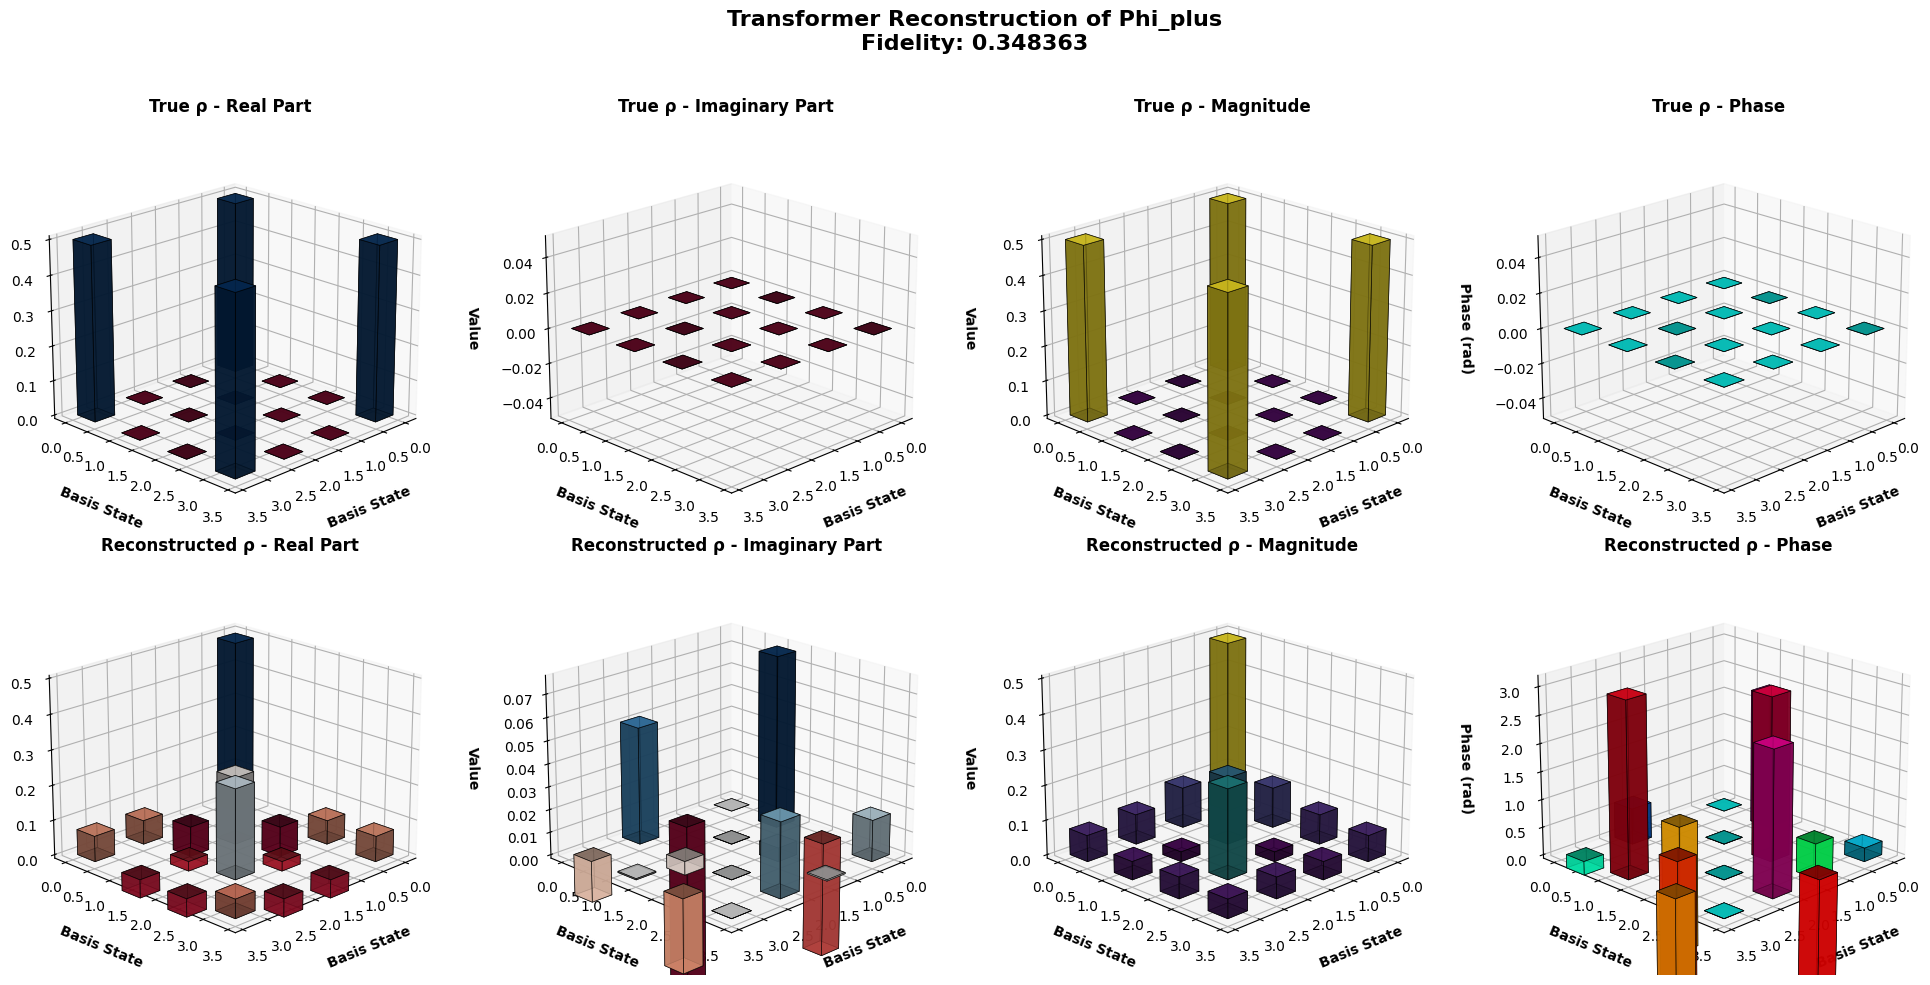

Fidelity: 0.348363

Testing Phi_minus...
State vector: [ 0.70710678+0.j  0.        +0.j  0.        +0.j -0.70710678+0.j]
  Probability sum check: 0.999999940395355
  Frequency sum: 1.000000000000000
  Reconstructing with SNN... 

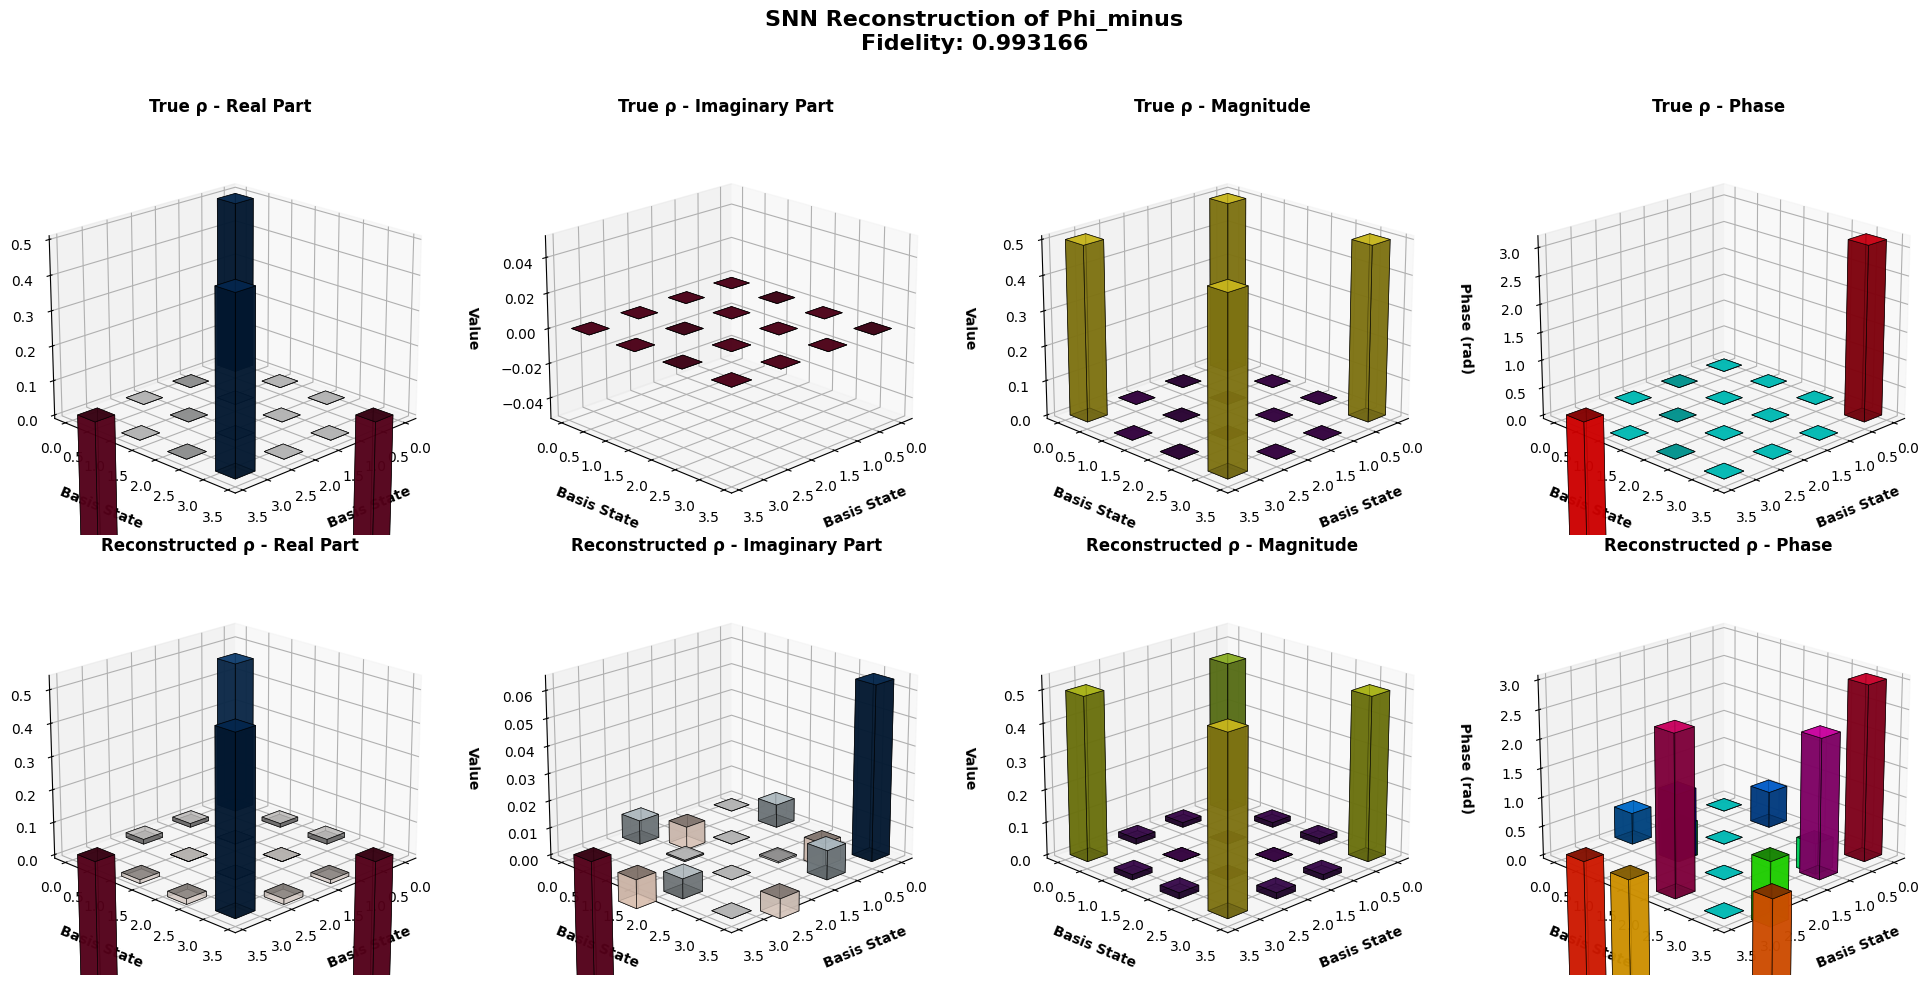

Fidelity: 0.993166
  Reconstructing with Transformer... 

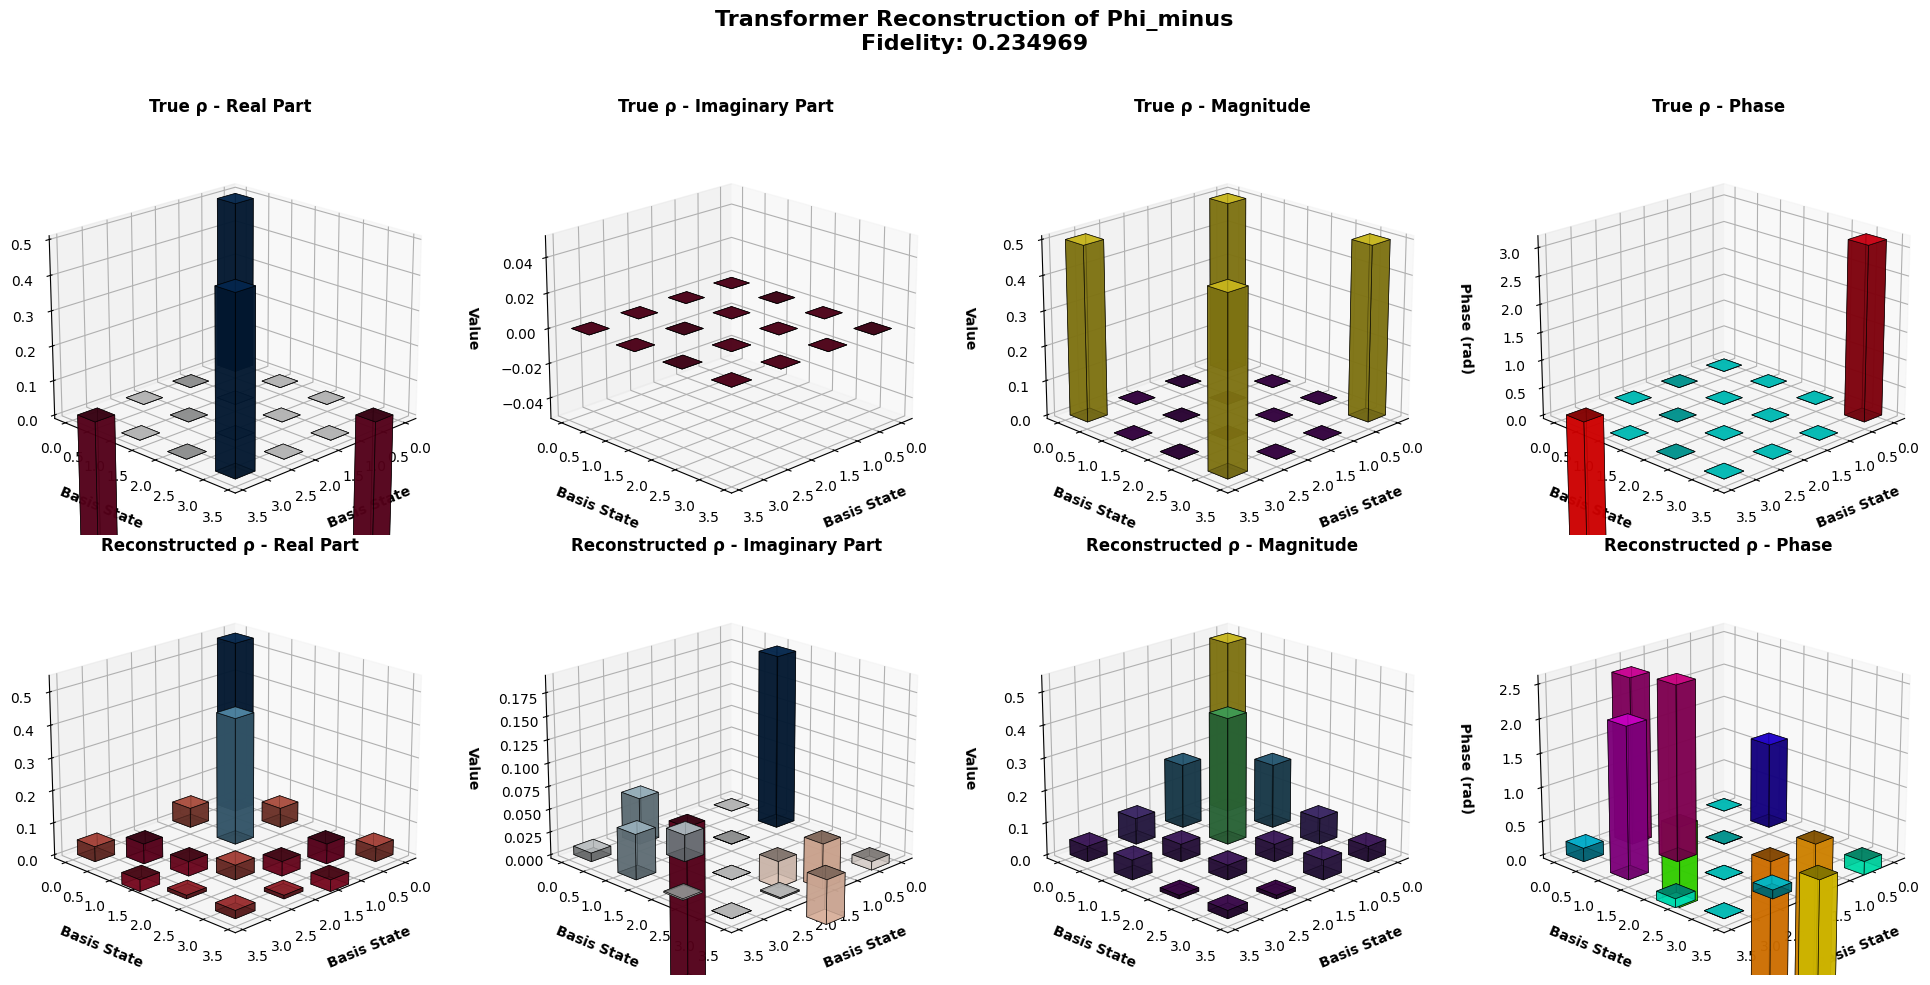

Fidelity: 0.234969

Testing Psi_plus...
State vector: [0.        +0.j 0.70710678+0.j 0.70710678+0.j 0.        +0.j]
  Probability sum check: 1.000000000000000
  Frequency sum: 1.000000000000000
  Reconstructing with SNN... 

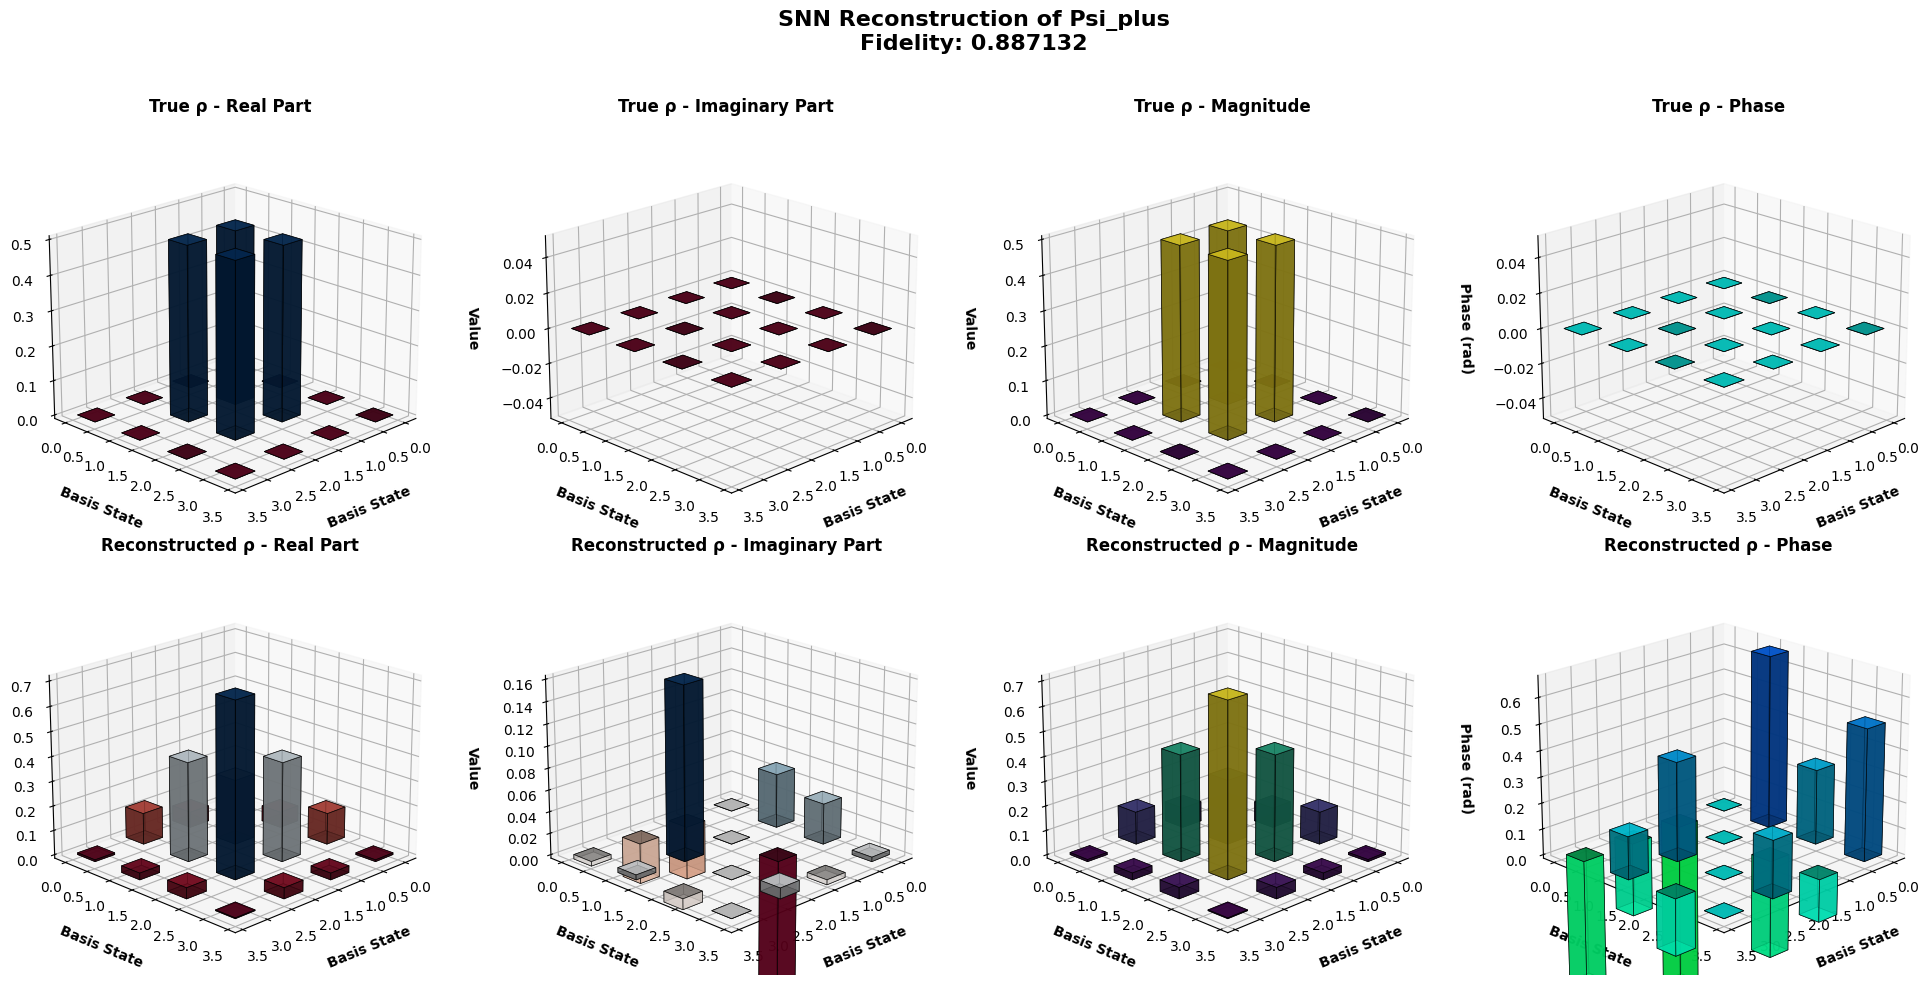

Fidelity: 0.887132
  Reconstructing with Transformer... 

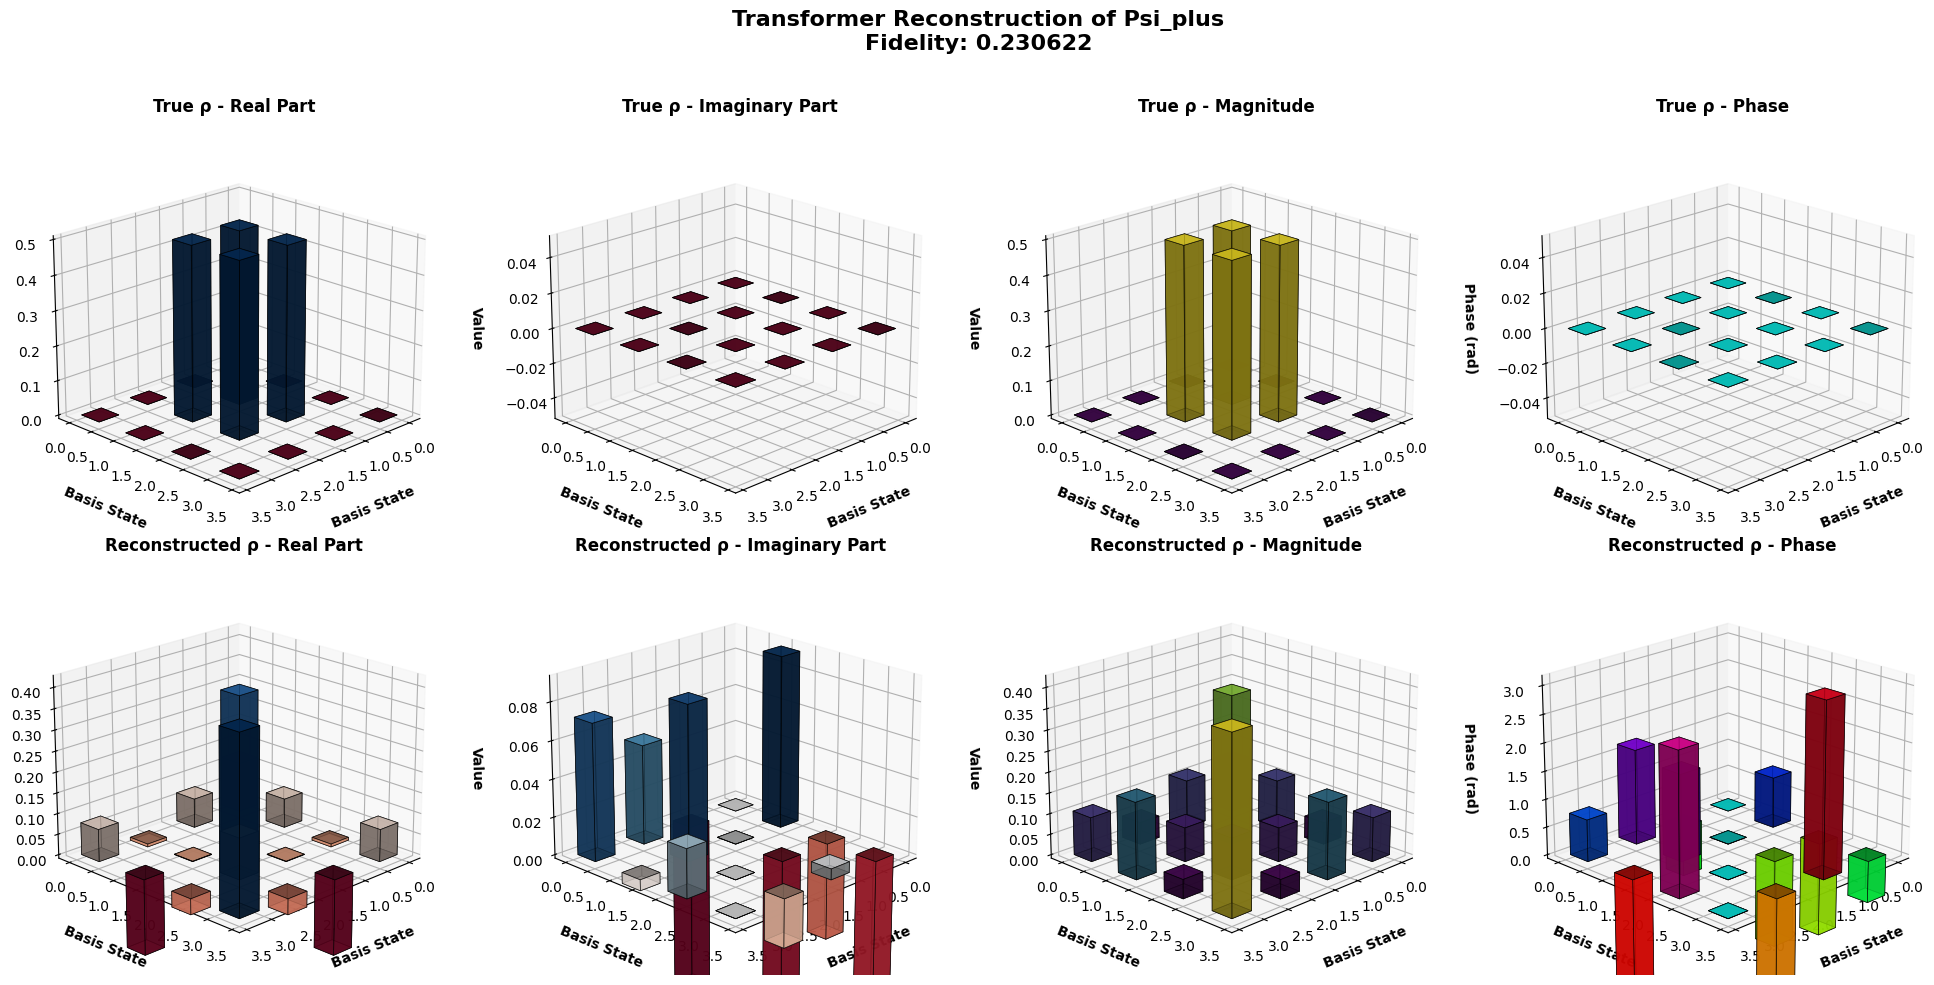

Fidelity: 0.230622

Testing Psi_minus...
State vector: [ 0.        +0.j  0.70710678+0.j -0.70710678+0.j  0.        +0.j]
  Probability sum check: 1.000000000000000
  Frequency sum: 1.000000000000000
  Reconstructing with SNN... 

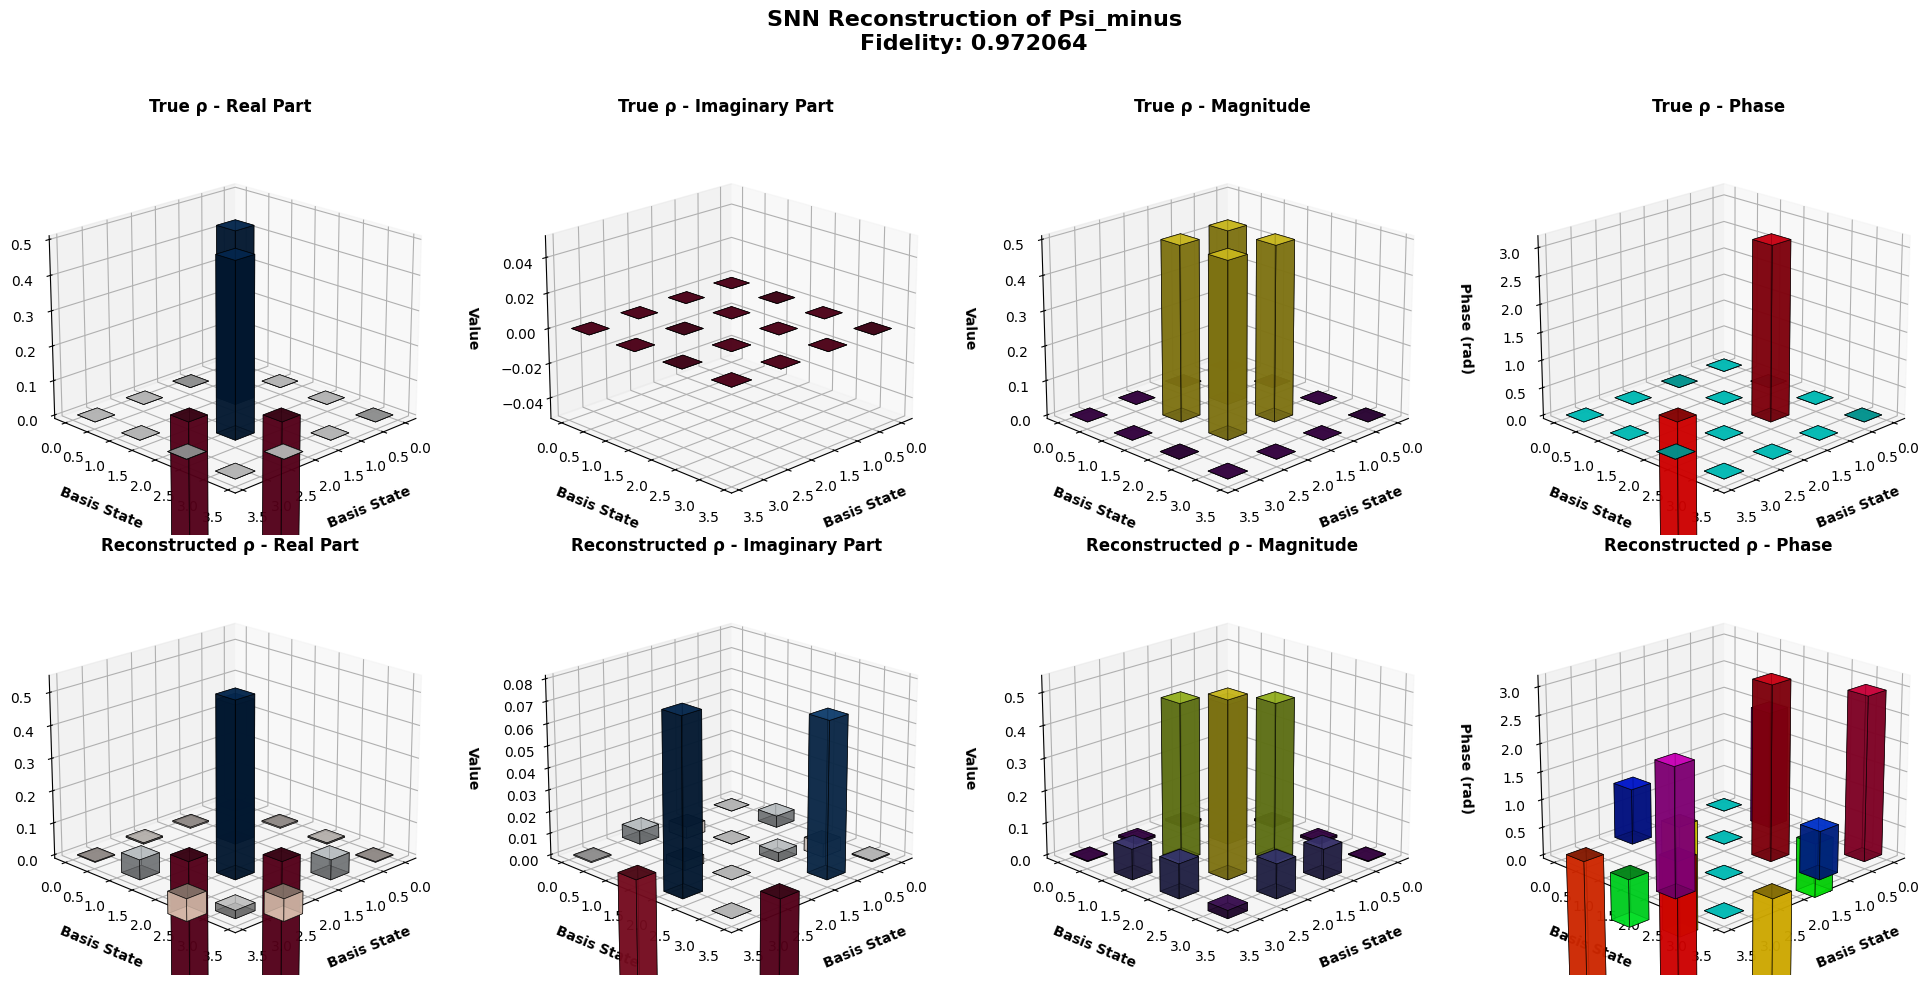

Fidelity: 0.972064
  Reconstructing with Transformer... 

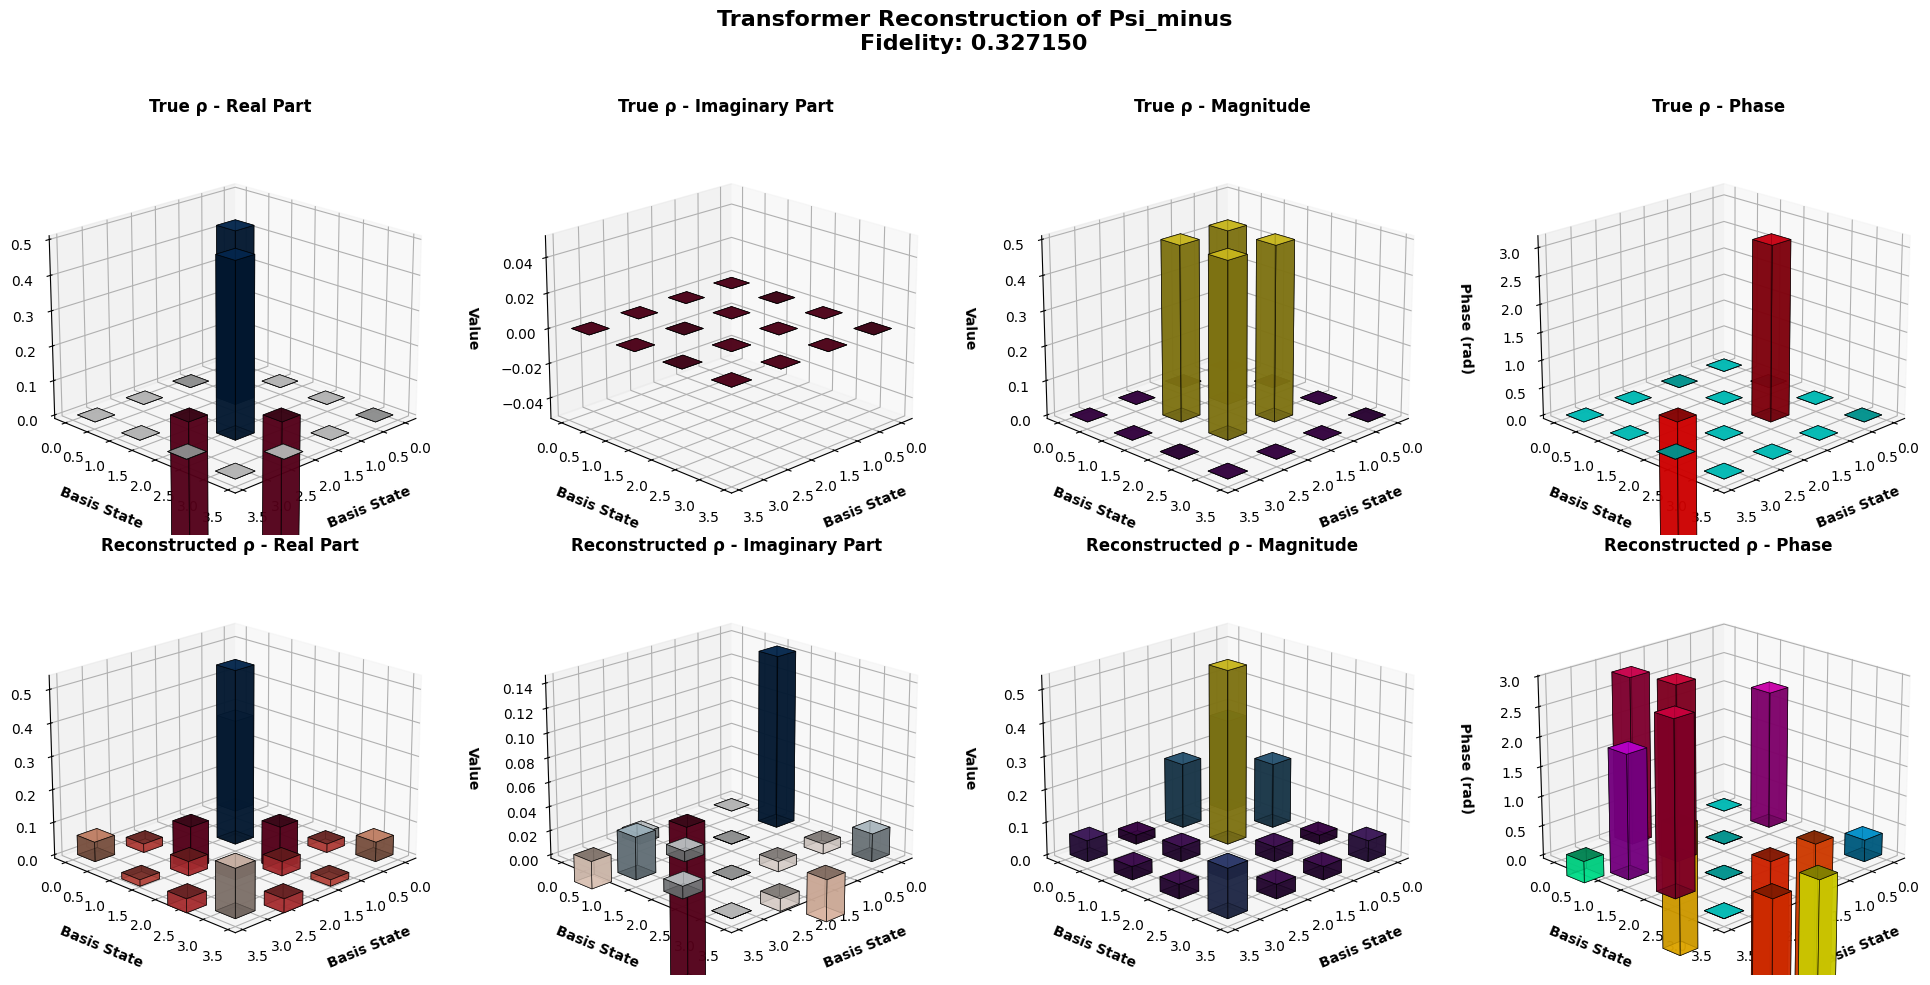

Fidelity: 0.327150

✓ Bell state testing completed!
  Generated 3D histogram plots for each Bell state and model
  - bell_states_summary.png
  - bell_*_SNN_3d.png
  - bell_*_TRF_3d.png


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

# Configure matplotlib for better rendering
import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'

# ------------------ Bell State Testing ------------------

def create_bell_states():
    """Create the four Bell states"""
    bell_states = {}
    
    # |Φ+⟩ = (|00⟩ + |11⟩)/√2
    phi_plus = np.zeros(4, dtype=np.complex128)
    phi_plus[0] = 1/np.sqrt(2)  # |00⟩
    phi_plus[3] = 1/np.sqrt(2)  # |11⟩
    bell_states['Phi_plus'] = phi_plus
    
    # |Φ-⟩ = (|00⟩ - |11⟩)/√2
    phi_minus = np.zeros(4, dtype=np.complex128)
    phi_minus[0] = 1/np.sqrt(2)   # |00⟩
    phi_minus[3] = -1/np.sqrt(2)  # |11⟩
    bell_states['Phi_minus'] = phi_minus
    
    # |Ψ+⟩ = (|01⟩ + |10⟩)/√2
    psi_plus = np.zeros(4, dtype=np.complex128)
    psi_plus[1] = 1/np.sqrt(2)  # |01⟩
    psi_plus[2] = 1/np.sqrt(2)  # |10⟩
    bell_states['Psi_plus'] = psi_plus
    
    # |Ψ-⟩ = (|01⟩ - |10⟩)/√2
    psi_minus = np.zeros(4, dtype=np.complex128)
    psi_minus[1] = 1/np.sqrt(2)   # |01⟩
    psi_minus[2] = -1/np.sqrt(2)  # |10⟩
    bell_states['Psi_minus'] = psi_minus
    
    return bell_states

def safe_multinomial(n_shots, probs, epsilon=1e-10):
    """
    Safely generate multinomial samples with proper probability normalization
    
    Args:
        n_shots: number of shots
        probs: probability array
        epsilon: small value to ensure probabilities are valid
    
    Returns:
        counts array
    """
    # Convert to float64 for maximum precision
    probs = np.array(probs, dtype=np.float64)
    
    # Ensure non-negative
    probs = np.abs(probs)
    
    # Add small epsilon and renormalize
    probs = probs + epsilon
    probs = probs / np.sum(probs)
    
    # Final check: force last element to make sum exactly 1.0
    probs[-1] = 1.0 - np.sum(probs[:-1])
    
    # Ensure all are still non-negative after adjustment
    if probs[-1] < 0:
        # Redistribute the deficit
        deficit = -probs[-1]
        probs[-1] = 0
        probs[:-1] = probs[:-1] - deficit / (len(probs) - 1)
        probs = probs / np.sum(probs)
        probs[-1] = 1.0 - np.sum(probs[:-1])
    
    # Verify sum is 1.0
    assert np.abs(np.sum(probs) - 1.0) < 1e-8, f"Probabilities sum to {np.sum(probs)}"
    
    return np.random.multinomial(n_shots, probs)

def jitter_dirichlet(freqs, alpha=DIRICHLET_ALPHA):
    """Apply Dirichlet jittering for test-time augmentation"""
    if alpha <= 0:
        return freqs
    freqs_pos = np.maximum(freqs, 1e-10)
    alphas = freqs_pos * alpha
    jittered = np.random.dirichlet(alphas)
    return jittered.astype(np.float32)

def reconstruct_density_matrix(model, model_type, freqs, d, device):
    """Reconstruct density matrix using the specified model"""
    
    if model_type == 'SNN':
        # SNN: Use Poisson spike train encoding
        params_acc = None
        with torch.no_grad():
            for k in range(SNN_EVAL_ENSEMBLES):
                spikes = freq_to_poisson_spiketrain(freqs, T=POISSON_T, scale=POISSON_SCALE, 
                                                   rng=np.random.RandomState())
                xb = torch.tensor(spikes[None].transpose(1,0,2), dtype=torch.float32, device=device)
                out = model(xb).squeeze(0).detach().cpu().numpy()
                params_acc = out if params_acc is None else params_acc + out
        out_avg = params_acc / float(SNN_EVAL_ENSEMBLES)
        Tmat = np_vec_to_T(out_avg, d)
        rho = Tmat @ Tmat.conj().T
        rho /= np.trace(rho)
        
    elif model_type == 'TRF':
        # Transformer: Use Dirichlet jittering
        params_acc_rho = None
        with torch.no_grad():
            for k in range(TRF_EVAL_ENSEMBLES):
                f_ = jitter_dirichlet(freqs)
                x = torch.tensor(f_[None,:], dtype=torch.float32, device=device)
                out = model(x).squeeze(0)
                rho_trf = torch_cholesky_params_to_rho(out[None,:], d, device).squeeze(0).detach().cpu().numpy()
                params_acc_rho = rho_trf if params_acc_rho is None else params_acc_rho + rho_trf
        rho = params_acc_rho / float(TRF_EVAL_ENSEMBLES)
    
    return rho

def plot_density_matrix_3d(rho_true, rho_recon, title, filename):
    """Plot density matrices as 3D histograms"""
    
    fig = plt.figure(figsize=(20, 10))
    
    # Prepare data
    n = rho_true.shape[0]
    x = np.arange(n)
    y = np.arange(n)
    X, Y = np.meshgrid(x, y)
    
    # Flatten for bar3d
    x_flat = X.ravel()
    y_flat = Y.ravel()
    z_zero = np.zeros_like(x_flat)
    
    # Real parts
    dx = dy = 0.4
    
    # Row 1: True density matrix
    # Real part
    ax1 = fig.add_subplot(2, 4, 1, projection='3d')
    z_true_real = np.real(rho_true).ravel()
    colors_true_real = plt.cm.RdBu((z_true_real - z_true_real.min()) / (z_true_real.max() - z_true_real.min() + 1e-10))
    ax1.bar3d(x_flat, y_flat, z_zero, dx, dy, z_true_real, color=colors_true_real, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax1.set_xlabel('Basis State', fontweight='bold', labelpad=10)
    ax1.set_ylabel('Basis State', fontweight='bold', labelpad=10)
    ax1.set_zlabel('Value', fontweight='bold', labelpad=10)
    ax1.set_title('True ρ - Real Part', fontweight='bold', fontsize=12, pad=15)
    ax1.view_init(elev=20, azim=45)
    
    # Imaginary part
    ax2 = fig.add_subplot(2, 4, 2, projection='3d')
    z_true_imag = np.imag(rho_true).ravel()
    colors_true_imag = plt.cm.RdBu((z_true_imag - z_true_imag.min()) / (z_true_imag.max() - z_true_imag.min() + 1e-10))
    ax2.bar3d(x_flat, y_flat, z_zero, dx, dy, z_true_imag, color=colors_true_imag, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Basis State', fontweight='bold', labelpad=10)
    ax2.set_ylabel('Basis State', fontweight='bold', labelpad=10)
    ax2.set_zlabel('Value', fontweight='bold', labelpad=10)
    ax2.set_title('True ρ - Imaginary Part', fontweight='bold', fontsize=12, pad=15)
    ax2.view_init(elev=20, azim=45)
    
    # Magnitude
    ax3 = fig.add_subplot(2, 4, 3, projection='3d')
    z_true_abs = np.abs(rho_true).ravel()
    colors_true_abs = plt.cm.viridis((z_true_abs - z_true_abs.min()) / (z_true_abs.max() - z_true_abs.min() + 1e-10))
    ax3.bar3d(x_flat, y_flat, z_zero, dx, dy, z_true_abs, color=colors_true_abs, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax3.set_xlabel('Basis State', fontweight='bold', labelpad=10)
    ax3.set_ylabel('Basis State', fontweight='bold', labelpad=10)
    ax3.set_zlabel('Value', fontweight='bold', labelpad=10)
    ax3.set_title('True ρ - Magnitude', fontweight='bold', fontsize=12, pad=15)
    ax3.view_init(elev=20, azim=45)
    
    # Phase
    ax4 = fig.add_subplot(2, 4, 4, projection='3d')
    z_true_phase = np.angle(rho_true).ravel()
    colors_true_phase = plt.cm.hsv((z_true_phase + np.pi) / (2 * np.pi))
    ax4.bar3d(x_flat, y_flat, z_zero, dx, dy, z_true_phase, color=colors_true_phase, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax4.set_xlabel('Basis State', fontweight='bold', labelpad=10)
    ax4.set_ylabel('Basis State', fontweight='bold', labelpad=10)
    ax4.set_zlabel('Phase (rad)', fontweight='bold', labelpad=10)
    ax4.set_title('True ρ - Phase', fontweight='bold', fontsize=12, pad=15)
    ax4.view_init(elev=20, azim=45)
    
    # Row 2: Reconstructed density matrix
    # Real part
    ax5 = fig.add_subplot(2, 4, 5, projection='3d')
    z_recon_real = np.real(rho_recon).ravel()
    colors_recon_real = plt.cm.RdBu((z_recon_real - z_recon_real.min()) / (z_recon_real.max() - z_recon_real.min() + 1e-10))
    ax5.bar3d(x_flat, y_flat, z_zero, dx, dy, z_recon_real, color=colors_recon_real, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax5.set_xlabel('Basis State', fontweight='bold', labelpad=10)
    ax5.set_ylabel('Basis State', fontweight='bold', labelpad=10)
    ax5.set_zlabel('Value', fontweight='bold', labelpad=10)
    ax5.set_title('Reconstructed ρ - Real Part', fontweight='bold', fontsize=12, pad=15)
    ax5.view_init(elev=20, azim=45)
    
    # Imaginary part
    ax6 = fig.add_subplot(2, 4, 6, projection='3d')
    z_recon_imag = np.imag(rho_recon).ravel()
    colors_recon_imag = plt.cm.RdBu((z_recon_imag - z_recon_imag.min()) / (z_recon_imag.max() - z_recon_imag.min() + 1e-10))
    ax6.bar3d(x_flat, y_flat, z_zero, dx, dy, z_recon_imag, color=colors_recon_imag, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax6.set_xlabel('Basis State', fontweight='bold', labelpad=10)
    ax6.set_ylabel('Basis State', fontweight='bold', labelpad=10)
    ax6.set_zlabel('Value', fontweight='bold', labelpad=10)
    ax6.set_title('Reconstructed ρ - Imaginary Part', fontweight='bold', fontsize=12, pad=15)
    ax6.view_init(elev=20, azim=45)
    
    # Magnitude
    ax7 = fig.add_subplot(2, 4, 7, projection='3d')
    z_recon_abs = np.abs(rho_recon).ravel()
    colors_recon_abs = plt.cm.viridis((z_recon_abs - z_recon_abs.min()) / (z_recon_abs.max() - z_recon_abs.min() + 1e-10))
    ax7.bar3d(x_flat, y_flat, z_zero, dx, dy, z_recon_abs, color=colors_recon_abs, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax7.set_xlabel('Basis State', fontweight='bold', labelpad=10)
    ax7.set_ylabel('Basis State', fontweight='bold', labelpad=10)
    ax7.set_zlabel('Value', fontweight='bold', labelpad=10)
    ax7.set_title('Reconstructed ρ - Magnitude', fontweight='bold', fontsize=12, pad=15)
    ax7.view_init(elev=20, azim=45)
    
    # Phase
    ax8 = fig.add_subplot(2, 4, 8, projection='3d')
    z_recon_phase = np.angle(rho_recon).ravel()
    colors_recon_phase = plt.cm.hsv((z_recon_phase + np.pi) / (2 * np.pi))
    ax8.bar3d(x_flat, y_flat, z_zero, dx, dy, z_recon_phase, color=colors_recon_phase, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax8.set_xlabel('Basis State', fontweight='bold', labelpad=10)
    ax8.set_ylabel('Basis State', fontweight='bold', labelpad=10)
    ax8.set_zlabel('Phase (rad)', fontweight='bold', labelpad=10)
    ax8.set_title('Reconstructed ρ - Phase', fontweight='bold', fontsize=12, pad=15)
    ax8.view_init(elev=20, azim=45)
    
    # Calculate fidelity
    fid = fidelity_pure(rho_recon, rho_true)
    
    fig.suptitle(f'{title}\nFidelity: {fid:.6f}', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fid


def plot_bell_state_summary(results):
    """Create a summary plot comparing all models on all Bell states"""
    
    bell_names = list(results.keys())
    models = ['SNN', 'TRF']
    
    # Extract fidelities
    fidelities = {model: [results[bell][model] for bell in bell_names] for model in models}
    
    # Bar chart
    x = np.arange(len(bell_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create bars with more distinct colors and better visibility
    bars1 = ax.bar(x - width/2, fidelities['SNN'], width, label='SNN', 
                   color='#2E86AB', edgecolor='black', linewidth=2, alpha=0.85)
    bars2 = ax.bar(x + width/2, fidelities['TRF'], width, label='Transformer', 
                   color='#E63946', edgecolor='black', linewidth=2, alpha=0.85)  # Changed to red for better visibility
    
    def autolabel(bars, color='black'):
        """Add value labels on bars with better positioning"""
        for bar in bars:
            height = bar.get_height()
            # Position label above bar with offset
            ax.annotate(f'{height:.4f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 5),  # Increased offset
                       textcoords="offset points",
                       ha='center', va='bottom', 
                       fontsize=10, fontweight='bold',
                       color=color,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'))
    
    autolabel(bars1, color='#2E86AB')
    autolabel(bars2, color='#E63946')
    
    # Add horizontal reference line
    ax.axhline(y=1.0, color='green', linestyle=':', linewidth=2, alpha=0.6, label='Perfect Fidelity')
    
    # Improve axis labels and title
    ax.set_xlabel('Bell State', fontsize=14, fontweight='bold')
    ax.set_ylabel('Fidelity', fontsize=14, fontweight='bold')
    ax.set_title('Bell State Reconstruction Fidelity Comparison', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    
    # Use Unicode symbols for Bell states
    bell_labels = ['|Φ⁺⟩', '|Φ⁻⟩', '|Ψ⁺⟩', '|Ψ⁻⟩']
    ax.set_xticklabels(bell_labels, fontsize=14, fontweight='bold')
    
    # Set y-axis limits with better range
    min_fid = min(min(fidelities['SNN']), min(fidelities['TRF']))
    max_fid = max(max(fidelities['SNN']), max(fidelities['TRF']))
    y_range = max_fid - min_fid
    
    # If range is very small, use fixed range
    if y_range < 0.1:
        ax.set_ylim([0.85, 1.05])
    else:
        # Add 10% padding to the range
        ax.set_ylim([max(0, min_fid - 0.1 * y_range), min(1.05, max_fid + 0.1 * y_range)])
    
    # Improve legend
    ax.legend(fontsize=13, framealpha=0.95, loc='lower right', edgecolor='black', fancybox=True, shadow=True)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle='--', axis='y', linewidth=1)
    ax.set_axisbelow(True)
    
    # Add average performance text with better formatting
    avg_snn = np.mean(fidelities['SNN'])
    avg_trf = np.mean(fidelities['TRF'])
    textstr = f'Average Fidelity:\n' \
              f'SNN:         {avg_snn:.4f}\n' \
              f'Transformer: {avg_trf:.4f}\n' \
              f'Difference:  {abs(avg_snn - avg_trf):.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=2)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props, family='monospace')
    
    # Add a second statistics box
    std_snn = np.std(fidelities['SNN'])
    std_trf = np.std(fidelities['TRF'])
    statsstr = f'Std Deviation:\n' \
               f'SNN:         {std_snn:.4f}\n' \
               f'Transformer: {std_trf:.4f}'
    props2 = dict(boxstyle='round', facecolor='lightblue', alpha=0.9, edgecolor='black', linewidth=2)
    ax.text(0.98, 0.98, statsstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment='right', bbox=props2, family='monospace')
    
    plt.tight_layout()
    plt.savefig('bell_states_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary table
    print(f"\n{'='*80}")
    print(f"{'BELL STATE FIDELITY SUMMARY':^80}")
    print(f"{'='*80}")
    print(f"\n{'Bell State':<20} {'SNN':<20} {'Transformer':<20} {'Best Model':<15}")
    print(f"{'-'*80}")
    
    for bell in bell_names:
        snn_fid = results[bell]['SNN']
        trf_fid = results[bell]['TRF']
        best = 'SNN' if snn_fid > trf_fid else 'Transformer'
        print(f"{bell:<20} {snn_fid:<20.6f} {trf_fid:<20.6f} {best:<15}")
    
    print(f"{'-'*80}")
    print(f"{'Average':<20} {avg_snn:<20.6f} {avg_trf:<20.6f}")
    print(f"{'='*80}\n")
    
    # Additional statistics
    print(f"\n{'STATISTICAL ANALYSIS':^80}")
    print(f"{'='*80}")
    min_snn = np.min([results[bell]['SNN'] for bell in bell_names])
    max_snn = np.max([results[bell]['SNN'] for bell in bell_names])
    min_trf = np.min([results[bell]['TRF'] for bell in bell_names])
    max_trf = np.max([results[bell]['TRF'] for bell in bell_names])
    
    print(f"SNN Statistics:")
    print(f"  Mean:   {avg_snn:.6f}")
    print(f"  Std:    {std_snn:.6f}")
    print(f"  Min:    {min_snn:.6f}")
    print(f"  Max:    {max_snn:.6f}")
    print(f"\nTransformer Statistics:")
    print(f"  Mean:   {avg_trf:.6f}")
    print(f"  Std:    {std_trf:.6f}")
    print(f"  Min:    {min_trf:.6f}")
    print(f"  Max:    {max_trf:.6f}")
    print(f"{'='*80}\n")

def test_bell_states_all_models(snn_model, trf_model, shots=1000):
    """Test SNN and Transformer models on all four Bell states"""
    
    bell_states = create_bell_states()
    results = {}
    
    print(f"\n{'='*80}")
    print(f"{'BELL STATE TOMOGRAPHY TEST':^80}")
    print(f"{'='*80}")
    print(f"Number of shots: {shots}\n")
    
    for bell_name, state_vec in bell_states.items():
        print(f"\nTesting {bell_name}...")
        print(f"State vector: {state_vec}")
        
        # Generate true density matrix
        rho_true = np.outer(state_vec, state_vec.conj()).astype(np.complex64)
        
        # Generate measurement frequencies with safe multinomial
        probs = sic_probs_from_state(state_vec)
        
        # Use safe multinomial
        counts = safe_multinomial(shots, probs)
        freqs = counts / float(np.sum(counts)) if np.sum(counts) > 0 else counts
        
        print(f"  Probability sum check: {np.sum(probs):.15f}")
        print(f"  Frequency sum: {np.sum(freqs):.15f}")
        
        results[bell_name] = {}
        
        # Test SNN
        print(f"  Reconstructing with SNN...", end=' ')
        rho_snn = reconstruct_density_matrix(snn_model, 'SNN', freqs, d, DEVICE)
        fid_snn = plot_density_matrix_3d(
            rho_true, rho_snn, 
            f'SNN Reconstruction of {bell_name}',
            f'bell_{bell_name}_SNN_3d.png'
        )
        results[bell_name]['SNN'] = fid_snn
        print(f"Fidelity: {fid_snn:.6f}")
        
        # Test Transformer
        print(f"  Reconstructing with Transformer...", end=' ')
        rho_trf = reconstruct_density_matrix(trf_model, 'TRF', freqs, d, DEVICE)
        fid_trf = plot_density_matrix_3d(
            rho_true, rho_trf,
            f'Transformer Reconstruction of {bell_name}',
            f'bell_{bell_name}_TRF_3d.png'
        )
        results[bell_name]['TRF'] = fid_trf
        print(f"Fidelity: {fid_trf:.6f}")
    
    # Summary plot
    # plot_bell_state_summary(results)
    
    return results

# Run the Bell state tests
print("\n=== Testing Models on Bell States (3D Visualization) ===\n")
bell_results = test_bell_states_all_models(snn_model, trf_model, shots=1000)

print("\n✓ Bell state testing completed!")
print("  Generated 3D histogram plots for each Bell state and model")
print("  - bell_states_summary.png")
print("  - bell_*_SNN_3d.png")
print("  - bell_*_TRF_3d.png")

##  Conclusion

- Demonstrated **Quantum State Tomography** using **Spiking Neural Networks**.
- Achieved **high fidelity reconstruction** with **low power consumption**.
- The SNN model naturally aligns with **quantum measurement statistics** (spikes ↔ measurement events).
- Proved scalability and robustness for multi-qubit systems using **SIC-POVM datasets**.

---

## Future Work

1. **Hardware Co-design:** Implement neuromorphic chips integrated with cryogenic qubit controllers.  
2. **On-chip Learning:** Enable closed-loop learning via real-time quantum measurements.  
3. **Quantum Neuromorphic Accelerators:** Explore event-driven hybrid QML models (e.g., Quantum-SNN GANs).  
4. **Multi-qubit Tomography:** Extend to 5–10 qubits using Tensor-Network-inspired architectures.  
5. **Quantum Error Mitigation:** Use SNN-based denoisers for noisy intermediate-scale quantum (NISQ) devices.

---


## References

1. *Quantum State Tomography with Spiking Neural Networks* — [arXiv:2008.01039](https://arxiv.org/pdf/2008.01039)
2. *Neuromorphic Quantum Tomography and Hybrid QML Systems* — [arXiv:2507.23007](https://arxiv.org/pdf/2507.23007)
3. *Neuromorphic Computing and Quantum Hardware Co-design* — [YouTube Lecture Series (QML 2025)](https://www.youtube.com/watch?v=WPiD1v40OOE&list=PLjJxSEx3Gi2jtzfBf_1t2DHnac9K-QUBf&index=5)
4. M. Nielsen and I. Chuang, *Quantum Computation and Quantum Information*.